In [1]:
#improts
import os
import shutil
import time
import zipfile
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms

# TP 5 Groove detection:


## 1. Explore the data:
Here we load some samples and visualize them

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
HOME_PATH= '/content/drive/MyDrive/Geosciences/'
DATA_PATH= HOME_PATH+ 'data/'

In [4]:
data_dir = '/content/data/'
os.makedirs(data_dir, exist_ok=True)

# Paths to the zip files
train_path = DATA_PATH + 'X_train.zip'
test_path = DATA_PATH + 'X_test.zip'

# Extract X_train.zip into train folder
with zipfile.ZipFile(train_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir+'train/')

# Extract X_test.zip into test folder
with zipfile.ZipFile(test_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir+'test/')

# Move y_train.csv to the train folder
shutil.copy(DATA_PATH +'y_train.csv', data_dir+'train/')

'/content/data/train/y_train.csv'

The number of train images is: 9670
The number of test images is: 2538


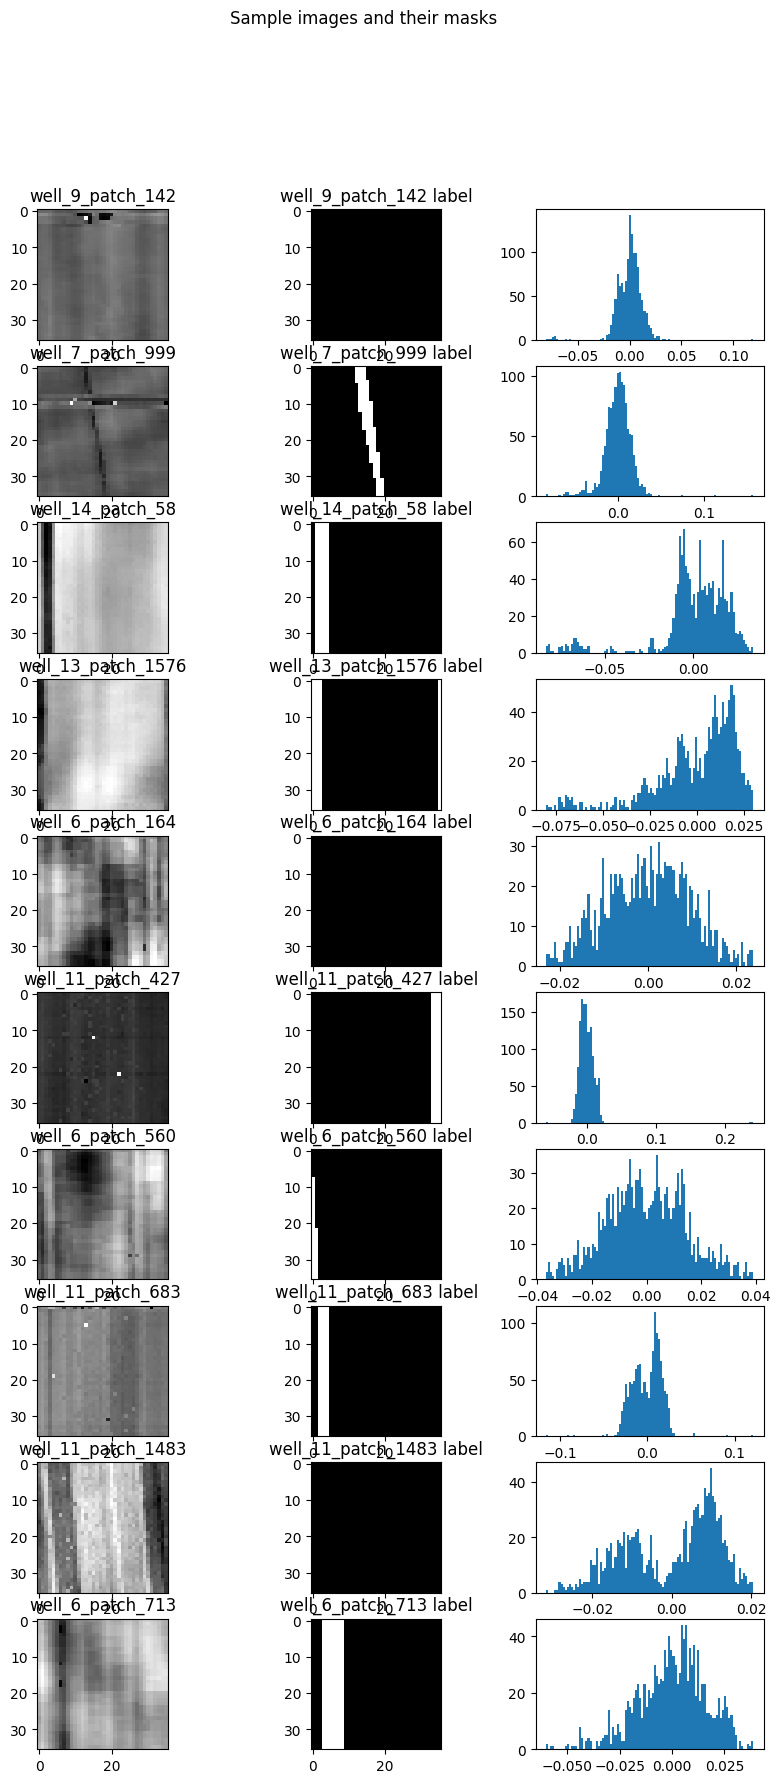

In [5]:
data_dir = '/content/data/'
train_images_path = os.path.join(data_dir, 'train/images/')
test_images_path = os.path.join(data_dir, 'test/images/')
train_labels_path = os.path.join(data_dir, 'train/y_train.csv')

# Number of train and test images
train_images_count = len(os.listdir(train_images_path))
test_images_count = len(os.listdir(test_images_path))
print(f'The number of train images is: {train_images_count}')
print(f'The number of test images is: {test_images_count}')

# Load train labels
y_train = pd.read_csv(train_labels_path, index_col=0)

# Access one patch label
patch_label = np.array(y_train.loc['well_1_patch_130']).reshape(36*36)

# Load one image
img0_path = os.path.join(train_images_path, 'well_1_patch_130.npy')
img0 = np.load(img0_path)

# Display sample images, labels, and histograms
img_files = os.listdir(train_images_path)[6459:6469]
fig, axes = plt.subplots(10, 3, figsize=(10, 20))

for i, name in enumerate(img_files):
    img = np.load(os.path.join(train_images_path, name))
    label = np.array(y_train.loc[name.split('.')[0]]).reshape(36, 36)
    img_flat = img.flatten()

    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].set_title(name.split('.')[0])

    axes[i, 1].imshow(label, cmap='gray')
    axes[i, 1].set_title(name.split('.')[0] + ' label')

    axes[i, 2].hist(img_flat, bins=100)

plt.suptitle('Sample images and their masks')
plt.show()

we see that most pixel intensities are cented around zero

### Create dataset class and import data
Here we also created a custom transform (Filter_images) to detect images with nan values and replace them with None, it will also clamp the images into interval (-3,3) that we assume will cover the dynamic range of intensities and remove undesirable values, namely -999. that we noticed in some images. then filter them using Filter_images

In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data, transform=None, train=True):
        self.path = path_to_data
        self.transform = transform
        self.train= train
        self.image_names = os.listdir(os.path.join(self.path, 'images'))

        if self.train:
          self.labels = pd.read_csv(os.path.join(self.path, 'y_train.csv'), index_col=0)
          #.values.reshape((-1, 36, 36))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, i):
        image_name = self.image_names[i]
        path= os.path.join(self.path, 'images', image_name)
        image = self.load_image(path)
        if self.train:
            label = torch.from_numpy(self.labels.loc[image_name.split('.')[0]].values.reshape((36, 36))).unsqueeze(0)
            if self.transform:
              image = self.transform(image)
              label= self.transform(label)
            return image, label
        else:
          if self.transform:
              image = self.transform(image)
          return image, image_name.split('.')[0]
    def load_image(self,path):
      img = torch.from_numpy(np.load(path)).unsqueeze(0).float()
      return img


class Filtered_Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.flt= [(img, label) for (img, label) in dataset if img is not None]
    def __len__(self):
        return len(self.flt)
    def __getitem__(self, i):
        image, label= self.flt[i]
        return image, label


In [7]:
class Filter_images(object):
    def __init__(self, range):
        self.min, self.max= range
    def __call__(self, image):
        if torch.isnan(image).any():
            return None
        else:
            image= torch.clamp(image, self.min, self.max)
        return image




In [22]:
data_dir = '/content/data/'
train_path= data_dir+'train/'
test_path=data_dir+'test/'
batch_size= 128

compose= Filter_images([-3, 3]) #large enough range

data_set= MyDataset(train_path, transform=compose)
data_set= Filtered_Dataset(data_set)
train_set, val_set= torch.utils.data.random_split(data_set, [0.8, 0.2])
test_set= MyDataset(train_path, transform=compose, train=False)

train_loader= DataLoader(train_set, batch_size, shuffle=True, drop_last=True)
val_loader= DataLoader(val_set, batch_size, shuffle=True, drop_last=True)
test_loader= DataLoader(test_set, batch_size, shuffle=False)

In [ ]:
#check dataset
for (image, label) in train_loader:
    if torch.isnan(image).all():
        print('nan')
    elif image == None:
        print('None')

    elif torch.min(image)<-3 or torch.max(image)>3:
        print('out of range')
print('all good')


all good


# 1.Train Baseline model:

Here we create a baseline segmentation model, that is composed of 5 convolution layers and LeakyReLU activation layers except for the last one which is a sigmoid.

In [ ]:
#baseline model:
class Baseline(nn.Module):
  def __init__(self):
    super(Baseline, self).__init__()

    self.convlayer= nn.Sequential(
        nn.Conv2d(1, 64,kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(64, 64,kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(64, 128,kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(128, 128,kernel_size=3, padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(128, 1, kernel_size=3, padding=1)
    )

    self.sigmoid= nn.Sigmoid()
  def forward(self, x):

    out= self.convlayer(x)
    out=self.sigmoid(out)

    return out

In [9]:
#helper functions:
def plot(images, masks, pred_masks):
    """
    Plots the first example of the batch for the original image, the ground truth mask,
    and the predicted mask side by side.

    Parameters:
    - images (Tensor): The batch of images from the dataset.
    - masks (Tensor): The batch of true masks corresponding to the images.
    - pred_masks (Tensor): The batch of predicted masks produced by the model.

    Returns:
    - fig, axs (matplotlib.figure.Figure, array of Axes): The figure and axes objects of the plot.
    """
    images = images.data.cpu().numpy()
    masks = masks.data.cpu().numpy()
    pred_masks = pred_masks.data.cpu().numpy()
    fig, axs = plt.subplots(1, 3, figsize=(12, 7))
    axs[0].imshow(images[0].reshape(36, 36, -1), cmap='gray')
    axs[0].set_title('Image')
    axs[1].imshow(masks[0].reshape(36, 36, -1), cmap='gray')
    axs[1].set_title('Ground Truth Mask')
    axs[2].imshow(pred_masks[0].reshape(36, 36, -1), cmap='gray')
    axs[2].set_title('Predicted Mask')
    return fig, axs

def dice_score(input, target, smooth=1.):
    """
    Calculates the Dice score, a measure of overlap between two samples.

    Parameters:
    - input (Tensor): Predicted masks.
    - target (Tensor): True masks.
    - smooth (float): A smoothing factor to avoid division by zero.

    Returns:
    - dice_score (float): The Dice score.
    """
    target = target.float()
    input = input.float()
    input_flat = input.view(-1)
    target_flat = target.view(-1)
    intersection = (input_flat * target_flat).sum()
    return (2. * intersection + smooth) / (input_flat.pow(2).sum() + target_flat.pow(2).sum() + smooth)

def dice_loss(input, target, smooth=1.):
    """
    Calculates the Dice loss, which is 1 minus the Dice score. This is used to minimize
    the difference between the predicted and true masks.

    Parameters:
    - input (Tensor): Predicted masks.
    - target (Tensor): True masks.
    - smooth (float): A smoothing factor to avoid division by zero.

    Returns:
    - dice_loss (float): The Dice loss.
    """
    dice = dice_score(input, target, smooth)
    return 1 - dice

def dice_bce_loss(input, target, smooth=1.):
    """
    Calculates a combined loss composed of the Dice loss and the Binary Cross-Entropy (BCE) loss.
    This can help leverage the advantages of both loss functions.

    Parameters:
    - input (Tensor): Predicted masks.
    - target (Tensor): True masks.
    - smooth (float): A smoothing factor to avoid division by zero.

    Returns:
    - combined_loss (float): The combined Dice and BCE loss.
    """
    dice = dice_loss(input, target, smooth)
    bce = F.binary_cross_entropy(input, target, reduction='mean')
    return dice + bce

In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
model= Baseline()
model.to(device)

Baseline(
  (convlayer): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (sigmoid): Sigmoid()
)

In [8]:
def train_loop(loader, model, criterion, optimizer):
  """
  Parameters:
    - loader (torch.utils.data.DataLoader): DataLoader for the dataset to iterate through.
    - model (torch.nn.Module): Neural network model to be trained or validated.
    - criterion (callable): Loss function to compute the error between predictions and targets.
    - optimizer (torch.optim.Optimizer): Optimizer used to update model parameters during training.

    Returns:
    - avg_loss (float): Average loss computed over all batches in the dataset.
    - avg_score (float): Average score computed over all batches in the dataset, using a scoring
      function defined outside this function (e.g., dice_score).
  """
    logging_mode= 'Train' if model.training else 'Val'
    loss=0
    score=0
    for  i, (images, masks) in enumerate(loader, 1):
        images = images.float().to(device)
        masks = masks.float().to(device)

        pred_masks= model(images)

        dice_loss= criterion(pred_masks, masks)
        if torch.isnan(dice_loss).all():
            pass

        dice_value= dice_score(pred_masks, masks)

        if logging_mode == 'Train':
          optimizer.zero_grad()
          dice_loss.backward()
          optimizer.step()
        loss+=dice_loss.item()
        score+= dice_value
    avg_loss= loss/len(loader) #average over length of loader
    avg_score= score/len(loader)
    if logging_mode== 'Val':
        fig, axs = plot(images, masks, pred_masks)
        plt.show()

    return avg_loss, avg_score

In [ ]:
learning_rate = 1e-2
criterion= nn.BCELoss()
# criterion= dice_bce_loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
save_path =HOME_PATH+ "save/"
if not os.path.isdir(save_path):
    os.makedirs(save_path)

Training
Validation


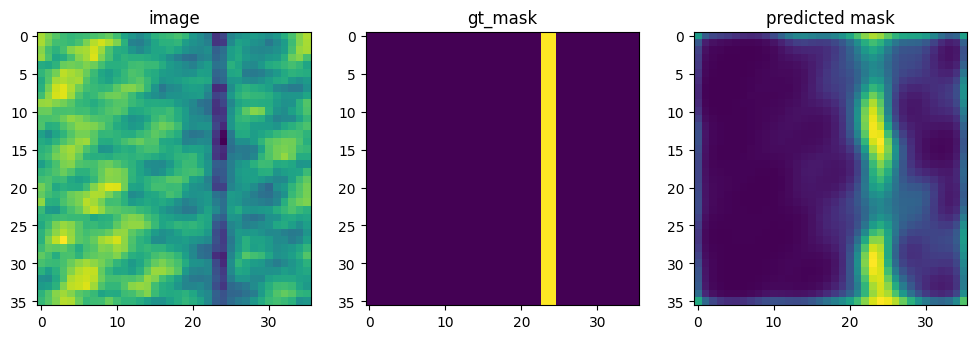

	 	 #####Epoch: 0###### 
 train_loss: 0.7329504661262035, train_score: 0.19533886015415192, val_loss: 0.20418052077293397, val_score: 0.3512628376483917 

Model saved at /kaggle/save/models/checkpoint.pth
Training
Validation


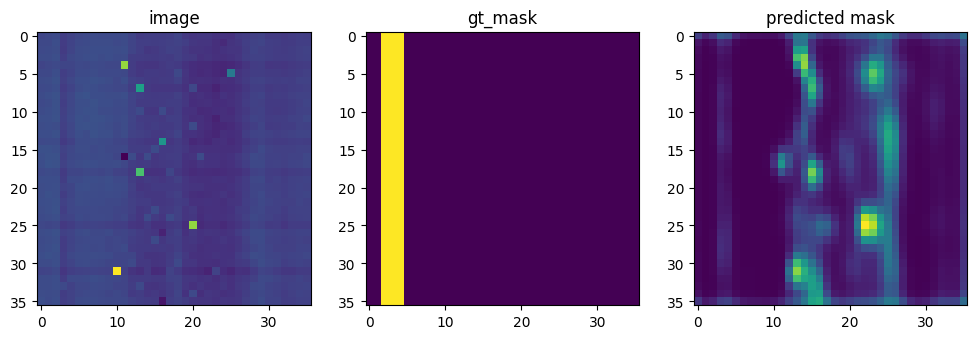

	 	 #####Epoch: 1###### 
 train_loss: 0.1751102256278197, train_score: 0.5207000374794006, val_loss: 0.14571542342503865, val_score: 0.6450452208518982 

Model saved at /kaggle/save/models/checkpoint.pth
Training
Validation


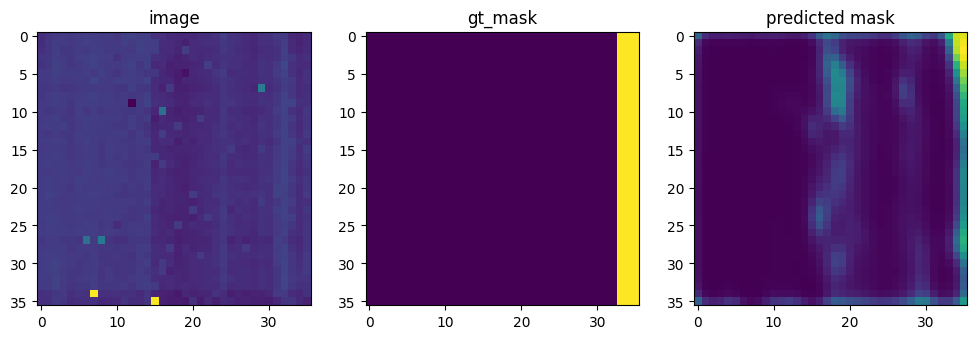

	 	 #####Epoch: 2###### 
 train_loss: 0.13837696487704912, train_score: 0.6611983776092529, val_loss: 0.13824176539977392, val_score: 0.6486137509346008 

Model saved at /kaggle/save/models/checkpoint.pth
Training
Validation


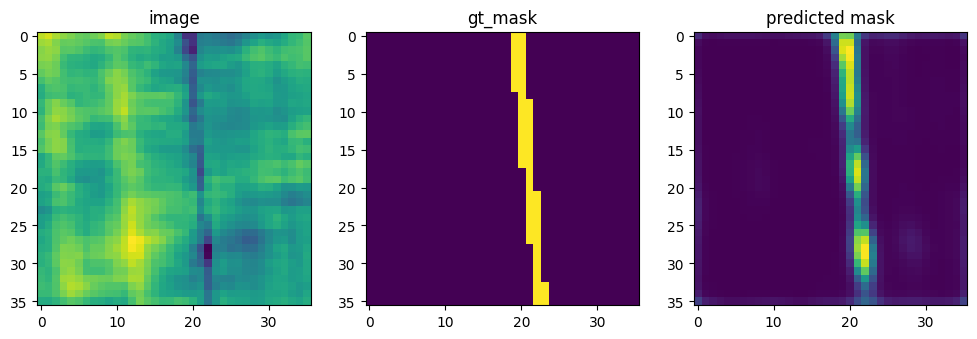

	 	 #####Epoch: 3###### 
 train_loss: 0.13208056824902695, train_score: 0.6788436770439148, val_loss: 0.13203165382146836, val_score: 0.6718305349349976 

Model saved at /kaggle/save/models/checkpoint.pth
Training
Validation


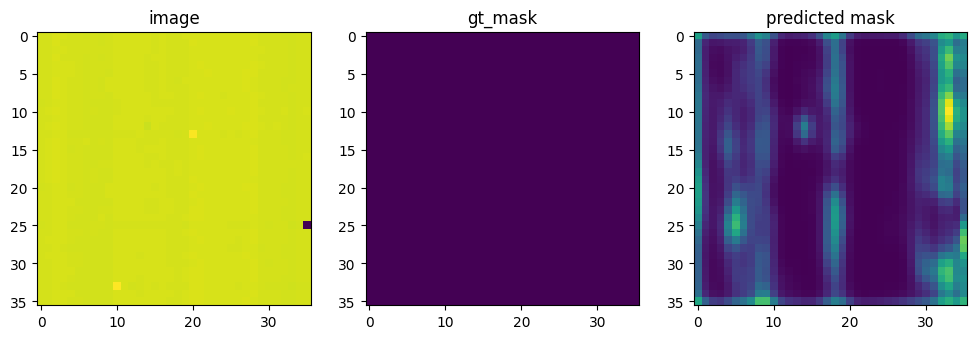

	 	 #####Epoch: 4###### 
 train_loss: 0.12840484703580538, train_score: 0.6865307092666626, val_loss: 0.13033323734998703, val_score: 0.693820059299469 

Model saved at /kaggle/save/models/checkpoint.pth
Training
Validation


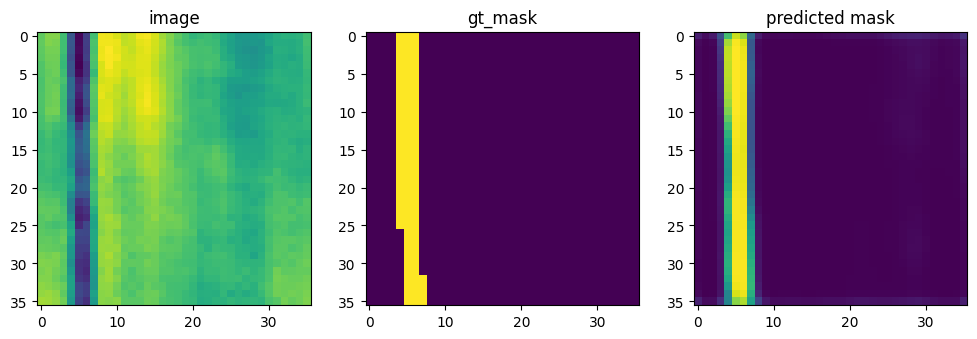

	 	 #####Epoch: 5###### 
 train_loss: 0.12660345894594988, train_score: 0.6917895078659058, val_loss: 0.12864994208017985, val_score: 0.6662642359733582 

Model saved at /kaggle/save/models/checkpoint.pth
Training
Validation


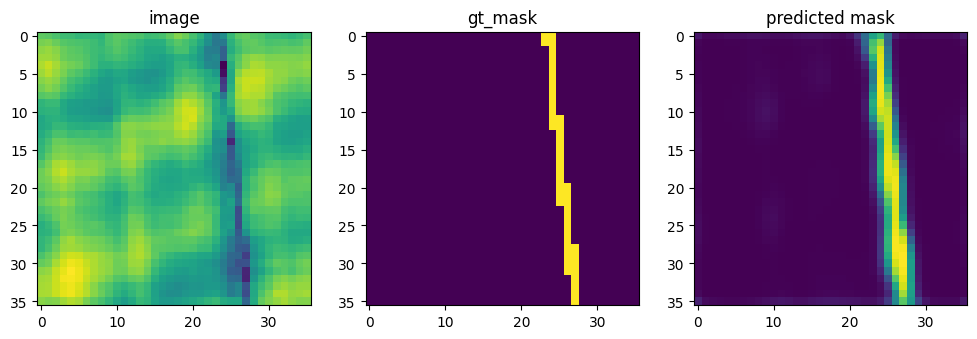

	 	 #####Epoch: 6###### 
 train_loss: 0.12419740209976832, train_score: 0.6951439380645752, val_loss: 0.12542656411727268, val_score: 0.6892530918121338 

Model saved at /kaggle/save/models/checkpoint.pth
Training
Validation


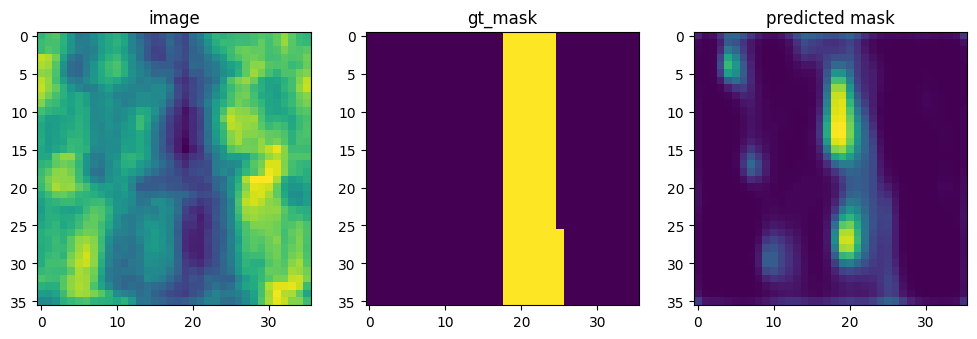

	 	 #####Epoch: 7###### 
 train_loss: 0.12401219817499319, train_score: 0.6955118775367737, val_loss: 0.12940406252940495, val_score: 0.7069886326789856 

Training
Validation


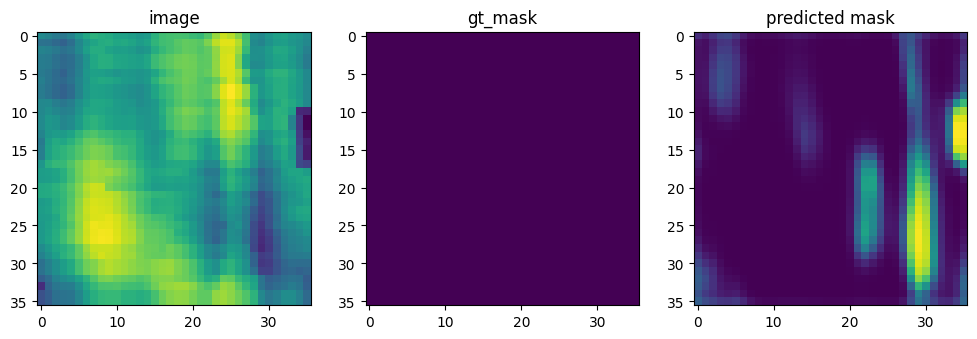

	 	 #####Epoch: 8###### 
 train_loss: 0.12295989307264486, train_score: 0.699650764465332, val_loss: 0.12395845552285513, val_score: 0.7014491558074951 

Model saved at /kaggle/save/models/checkpoint.pth
Training
Validation


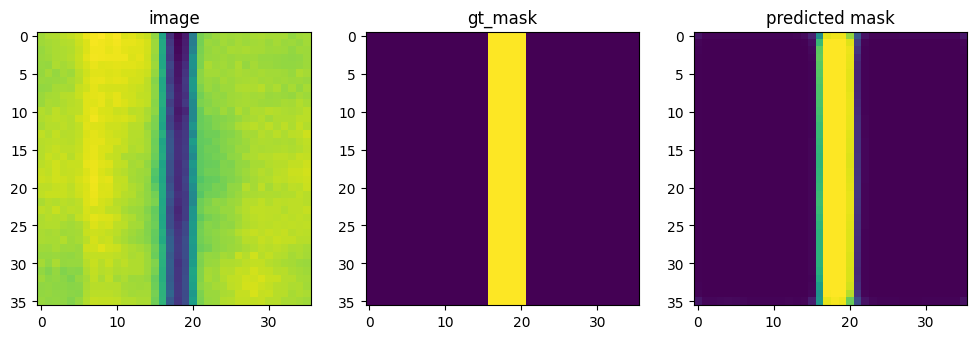

	 	 #####Epoch: 9###### 
 train_loss: 0.1213846364368995, train_score: 0.70184725522995, val_loss: 0.12244201997915903, val_score: 0.706899881362915 

Model saved at /kaggle/save/models/checkpoint.pth


In [ ]:
epochs = 10
save_model = False
train_losses, val_losses=[], []
train_scores, val_scores=[],[]
min_loss=10e7
for epoch in range(epochs):
    print('Training')
    model.train()
    avg_train_loss, avg_train_score = train_loop(train_loader, model, criterion, optimizer)

    print('Validation')
    with torch.no_grad():
        model.eval()
        avg_val_loss, avg_val_score = train_loop(val_loader, model, criterion, optimizer)

    print(f'\t \t #####Epoch: {epoch}###### \n train_loss: {avg_train_loss}, train_score: {avg_train_score}, val_loss: {avg_val_loss}, val_score: {avg_val_score} \n')
    if avg_val_loss < min_loss:
      min_loss = avg_val_loss
      os.makedirs(os.path.join(save_path,'models'), exist_ok= True)
      save = os.path.join(save_path,'models', 'checkpoint.pth')
      torch.save(model.state_dict(), save)
      print('Model saved at', save)


We could get a validation score of 0.71 on the baseline model

# 2.  UNET for segmentation:
In this part we create a Unet just as described in the original paper, with four Downsampling blocks and four upsampling blocks
![Unet Architecture](https://drive.google.com/uc?export=view&id=1I9NQL3nhM7J_9_uV70bxidshwb7fPKc9)



# Load the data
Reload the data and resize the images to (32,32) to make it a power of 2.

In [8]:
data_dir = '/content/data/'
train_path= data_dir+'train/'
test_path=data_dir+'test/'
batch_size= 128

compose= transforms.Compose([
    transforms.Resize((32,32)), #resize the images to power of 2 to avoid errors in upsampling part
    Filter_images([-3, 3]) #large enough range
])

data_set= MyDataset(train_path, transform=compose)
data_set= Filtered_Dataset(data_set)
train_set, val_set= torch.utils.data.random_split(data_set, [0.8, 0.2])
test_set= MyDataset(train_path, transform=compose, train=False)
test_set= Filtered_Dataset(test_set)
train_loader= DataLoader(train_set, batch_size, shuffle=True, drop_last=True)
val_loader= DataLoader(val_set, batch_size, shuffle=True, drop_last=True)
test_loader= DataLoader(test_set, batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [9]:
#check dataset
for (image, label) in test_set:
    # if torch.isnan(image).all():
    #     print('nan')
    if image == None:
        print('None', label)

    elif torch.min(image)<-3 or torch.max(image)>3:
        print('out of range')
print('all good')
print(len(test_set))

all good
9668


the test set initally contains 9670 images. the two images at well_15_patch_202 and well_15_patch_201 contain nan values so we discard them

## Build UNet model:

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.doubleConvLayer= nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU( inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )
    def forward(self, x):
        out= self.doubleConvLayer(x)
        return out

class DownSample(nn.Module):
    """ if input is [b_size, in_channels, h, w] returns out of size [b_size, out_channel, h/2, w/2]"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.doubleConvLayer= DoubleConv(in_channels, out_channels)
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
    def forward(self, x):
        cov= self.doubleConvLayer(x)
        out= self.maxpool(cov)
        return cov, out

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample= nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.doubleConvLayer= DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1= self.upsample(x1)
        x= torch.cat([x1, x2],1) #concat the output of the downsampler
        x=self.doubleConvLayer(x)
        return x

In [11]:
class My_unet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        # down sample layer
        self.downconv1= DownSample(in_channels, 64)
        self.downconv2= DownSample(64, 128)
        self.downconv3= DownSample(128, 256)
        self.downconv4= DownSample(256, 512)
        #conv layers in botelneck
        self.bottel= DoubleConv(512 , 1024)
        #upsample layers
        self.upconv1= UpSample(1024, 512)
        self.upconv2= UpSample(512, 256)
        self.upconv3= UpSample(256, 128)
        self.upconv4= UpSample(128, 64)
        #last conv layer
        self.out = nn.Conv2d(in_channels= 64, out_channels=out_channels, kernel_size=1)
        self.sigmoid= nn.Sigmoid()
    def forward(self, x):
        # print("Input:", x.size())

        cov1, down1 = self.downconv1(x)
        # print("After downconv1:", down1.size())

        cov2, down2 = self.downconv2(down1)
        # print("After downconv2:", down2.size())

        cov3, down3 = self.downconv3(down2)
        # print("After downconv3:", down3.size())

        cov4, down4 = self.downconv4(down3)
        # print("After downconv4:", down4.size())

        bottleneck = self.bottel(down4)
        # print("Bottleneck:", bottleneck.size())

        up1 = self.upconv1(bottleneck, cov4)
        # print("After upconv1:", up1.size())

        up2 = self.upconv2(up1, cov3)
        # print("After upconv2:", up2.size())

        up3 = self.upconv3(up2, cov2)
        # print("After upconv3:", up3.size())

        up4 = self.upconv4(up3, cov1)
        # print("After upconv4:", up4.size())

        out = self.sigmoid(self.out(up4))
        # print("Output:", out.size())
        return out


In [14]:
double_cov= DoubleConv(1,64)
down_sam= DownSample(1,64)
up_sam= UpSample(64,16)
l=nn.BCELoss()
une= My_unet(1,1)
layer=UpSample(4, 2).upsample
for i, (img, lab) in enumerate(train_loader):
    out= une(img).float()
    print(out.shape)

    break




Input: torch.Size([128, 1, 32, 32])
After downconv1: torch.Size([128, 64, 16, 16])
After downconv2: torch.Size([128, 128, 8, 8])
After downconv3: torch.Size([128, 256, 4, 4])
After downconv4: torch.Size([128, 512, 2, 2])
Bottleneck: torch.Size([128, 1024, 2, 2])
After upconv1: torch.Size([128, 512, 4, 4])
After upconv2: torch.Size([128, 256, 8, 8])
After upconv3: torch.Size([128, 128, 16, 16])
After upconv4: torch.Size([128, 64, 32, 32])
Output: torch.Size([128, 1, 32, 32])
torch.Size([128, 1, 32, 32])


In [12]:
def plot(images, masks, pred_masks):
    """
    Plots the first example of the batch for the original image, the ground truth mask,
    and the predicted mask side by side.

    Parameters:
    - images (Tensor): The batch of images from the dataset.
    - masks (Tensor): The batch of true masks corresponding to the images.
    - pred_masks (Tensor): The batch of predicted masks produced by the model.

    Returns:
    - fig, axs (matplotlib.figure.Figure, array of Axes): The figure and axes objects of the plot.
    """
    images = images.data.cpu().numpy()
    masks = masks.data.cpu().numpy()
    pred_masks = pred_masks.data.cpu().numpy()
    fig, axs = plt.subplots(1, 3, figsize=(12, 7))
    axs[0].imshow(images[0].reshape(36, 36, -1), cmap='gray')
    axs[0].set_title('Image')
    axs[1].imshow(masks[0].reshape(36, 36, -1), cmap='gray')
    axs[1].set_title('Ground Truth Mask')
    axs[2].imshow(pred_masks[0].reshape(36, 36, -1), cmap='gray')
    axs[2].set_title('Predicted Mask')
    return fig, axs

def dice_score(input, target, smooth=1.):
    """
    Calculates the Dice score, a measure of overlap between two samples.

    Parameters:
    - input (Tensor): Predicted masks.
    - target (Tensor): True masks.
    - smooth (float): A smoothing factor to avoid division by zero.

    Returns:
    - dice_score (float): The Dice score.
    """
    target = target.float()
    input = input.float()
    input_flat = input.view(-1)
    target_flat = target.view(-1)
    intersection = (input_flat * target_flat).sum()
    return (2. * intersection + smooth) / (input_flat.pow(2).sum() + target_flat.pow(2).sum() + smooth)

def dice_loss(input, target, smooth=1.):
    """
    Calculates the Dice loss, which is 1 minus the Dice score. This is used to minimize
    the difference between the predicted and true masks.

    Parameters:
    - input (Tensor): Predicted masks.
    - target (Tensor): True masks.
    - smooth (float): A smoothing factor to avoid division by zero.

    Returns:
    - dice_loss (float): The Dice loss.
    """
    dice = dice_score(input, target, smooth)
    return 1 - dice

def dice_bce_loss(input, target, smooth=1.):
    """
    Calculates a combined loss composed of the Dice loss and the Binary Cross-Entropy (BCE) loss.
    This can help leverage the advantages of both loss functions.

    Parameters:
    - input (Tensor): Predicted masks.
    - target (Tensor): True masks.
    - smooth (float): A smoothing factor to avoid division by zero.

    Returns:
    - combined_loss (float): The combined Dice and BCE loss.
    """
    dice = dice_loss(input, target, smooth)
    bce = F.binary_cross_entropy(input, target, reduction='mean')
    return dice + bce

In [13]:
# train with only two layers in the unet
device= 'cuda' if torch.cuda.is_available() else 'cpu'
model= My_unet(1,1)
model= model.to(device)

In [14]:
learning_rate = 5e-1
criterion= nn.BCELoss()
# criterion= dice_loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50

Epoch 0/49, Train Loss: 0.3228811410566171, Train Score: 0.13657568895384126, Val Loss: 0.2632623245318731, Val Score: 0.14055396219094593
Epoch 1/49, Train Loss: 0.26758888761202493, Train Score: 0.2234834880878528, Val Loss: 0.2434672753016154, Val Score: 0.20348105430603028
Epoch 2/49, Train Loss: 0.2283720314502716, Train Score: 0.34926180392503736, Val Loss: 0.24885022044181823, Val Score: 0.23972714245319365
Epoch 3/49, Train Loss: 0.18482689956823986, Train Score: 0.5344001322984695, Val Loss: 0.20930640598138173, Val Score: 0.4086887836456299
Epoch 4/49, Train Loss: 0.14691291004419327, Train Score: 0.6432760973771413, Val Loss: 0.2582507938146591, Val Score: 0.5706376592318217
Epoch 5/49, Train Loss: 0.1374411025394996, Train Score: 0.6648763865232468, Val Loss: 0.14399423102537792, Val Score: 0.691371750831604
Epoch 6/49, Train Loss: 0.13083014463384945, Train Score: 0.6757666766643524, Val Loss: 0.3527962863445282, Val Score: 0.5077086667219798
Epoch 7/49, Train Loss: 0.1265

<ipython-input-12-a32fafce1420>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs= plt.subplots(1,3,figsize=(12, 7))


Epoch 20/49, Train Loss: 0.09466284476220607, Train Score: 0.7775205284357071, Val Loss: 0.10862138321002325, Val Score: 0.7381308158238729
Epoch 21/49, Train Loss: 0.09228009482224782, Train Score: 0.7843351423740387, Val Loss: 0.0964660495519638, Val Score: 0.7715898672739665
Epoch 22/49, Train Loss: 0.09023934341967106, Train Score: 0.7890945881605148, Val Loss: 0.09820827593406041, Val Score: 0.7470894813537597
Epoch 23/49, Train Loss: 0.08680314222971598, Train Score: 0.7995654960473378, Val Loss: 0.09738386074701945, Val Score: 0.7707282265027364
Epoch 24/49, Train Loss: 0.0864225059747696, Train Score: 0.7991069356600443, Val Loss: 0.08676041066646575, Val Score: 0.7937984506289164
Epoch 25/49, Train Loss: 0.08566432806352774, Train Score: 0.8010454495747884, Val Loss: 0.11129905730485916, Val Score: 0.7635175307591756
Epoch 26/49, Train Loss: 0.08435883497198422, Train Score: 0.8045352756977081, Val Loss: 0.09724950542052586, Val Score: 0.7770633498827616
Epoch 27/49, Train Los

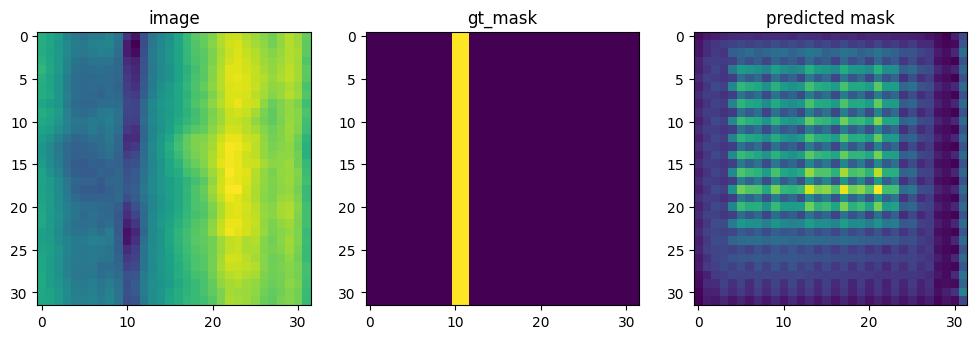

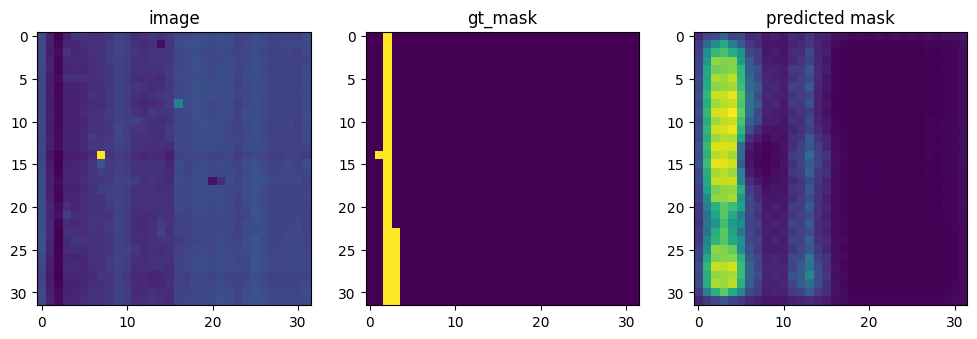

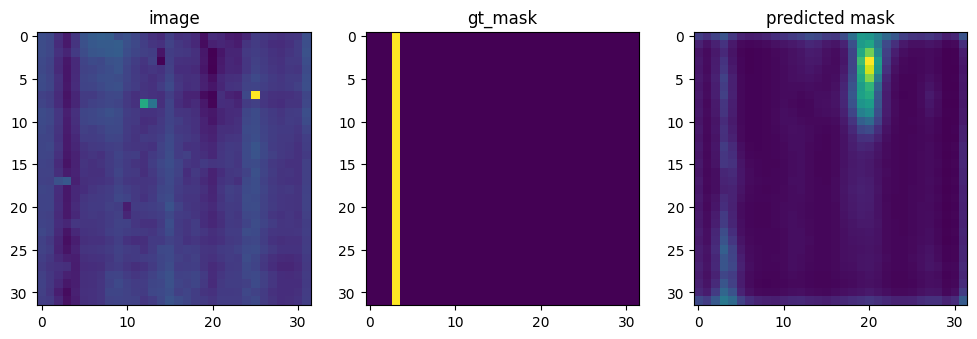

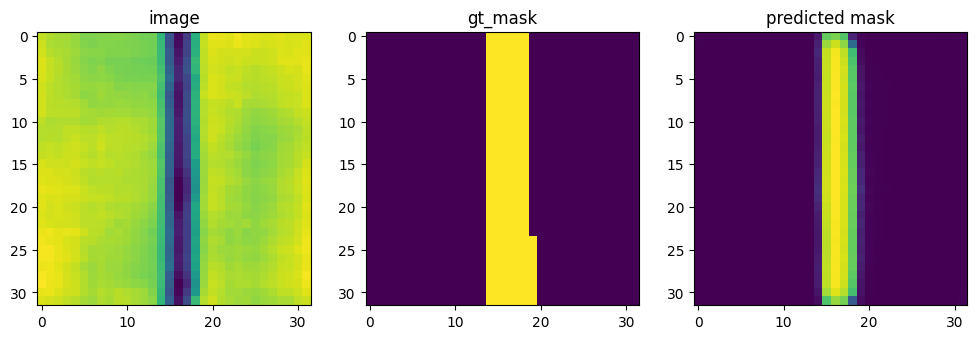

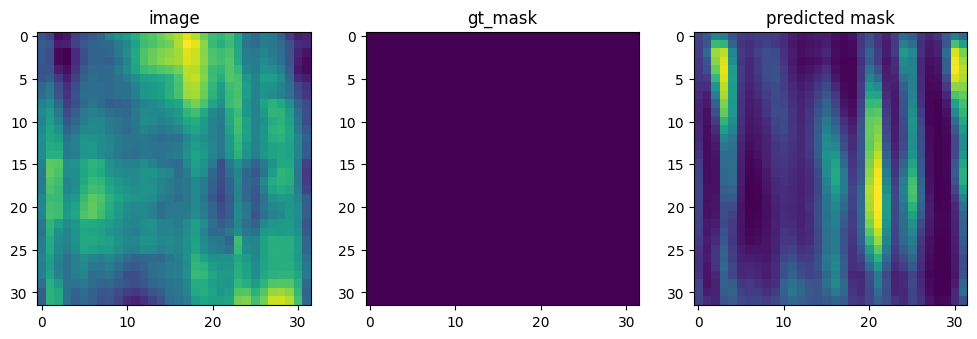

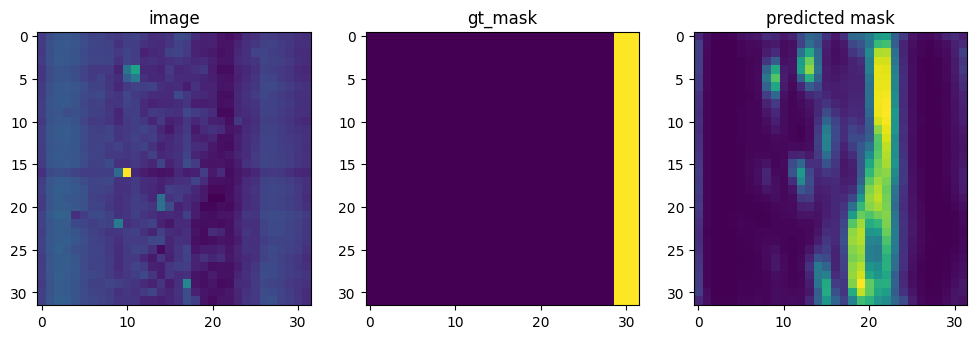

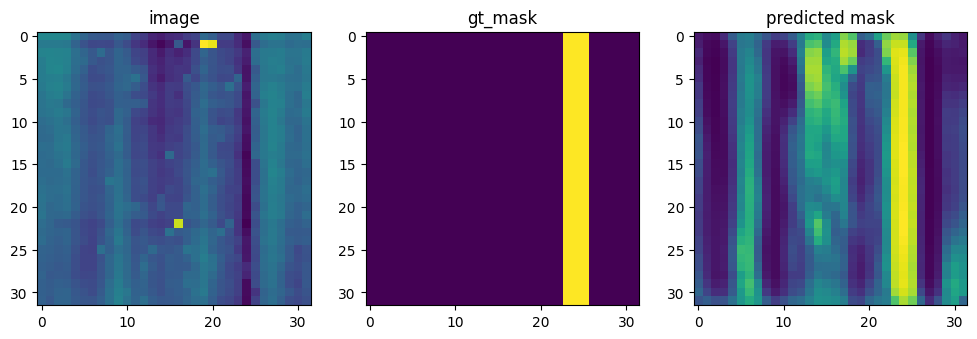

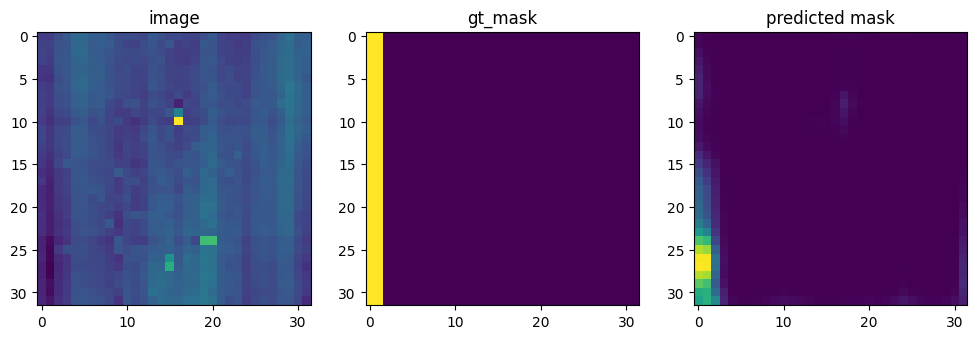

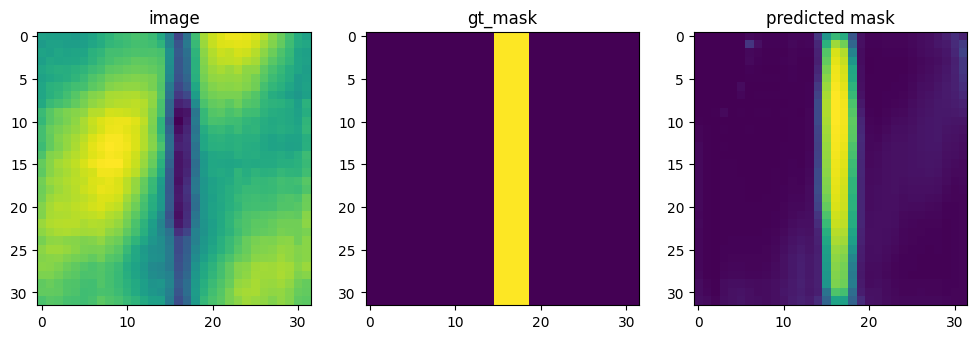

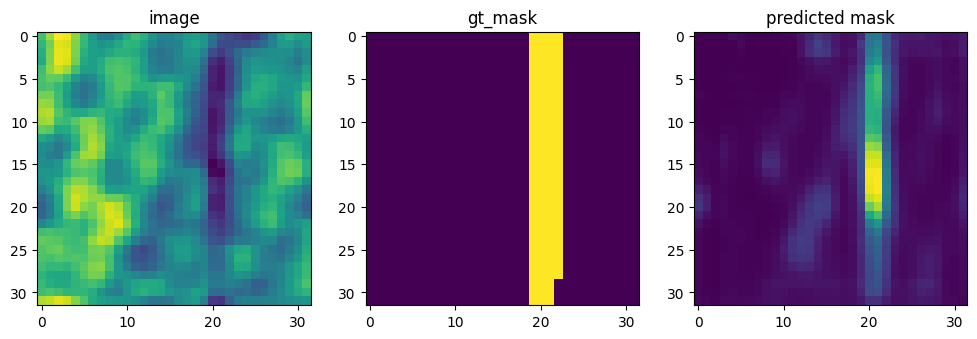

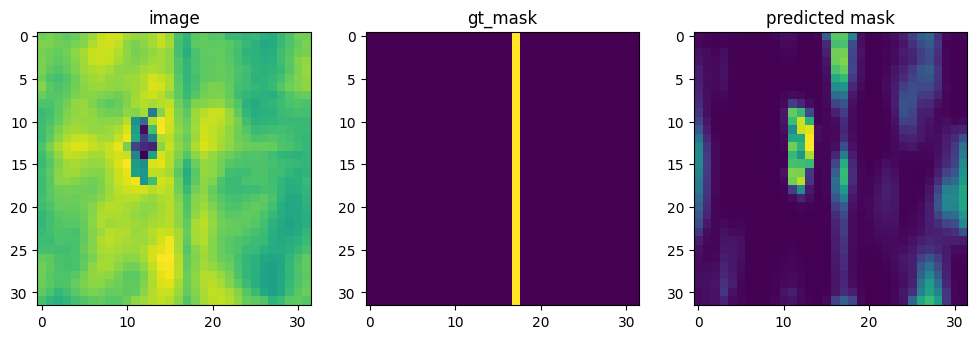

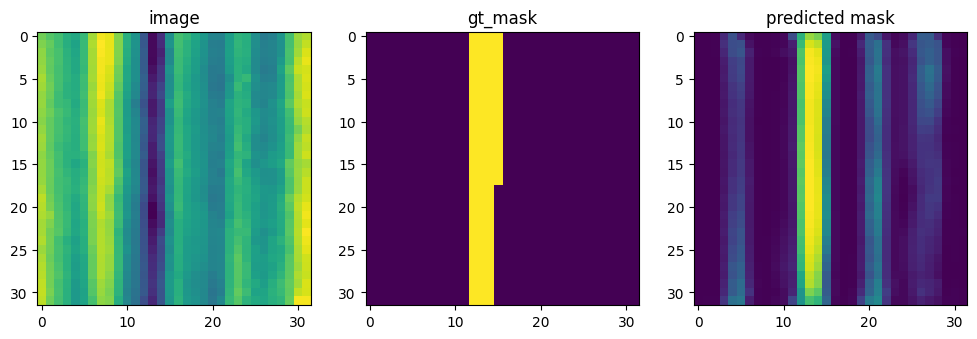

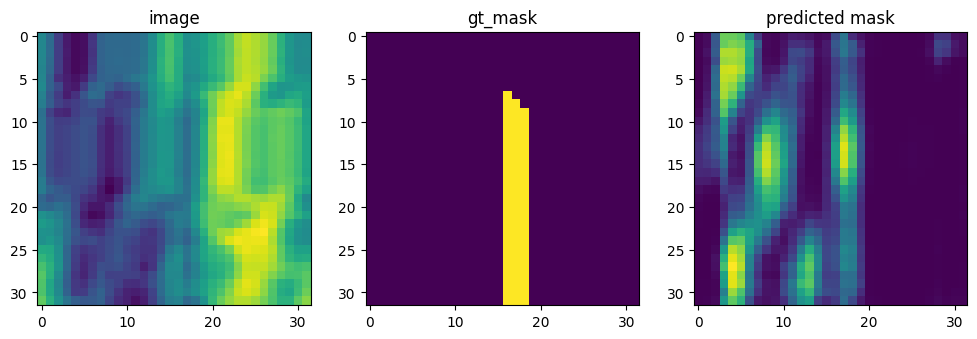

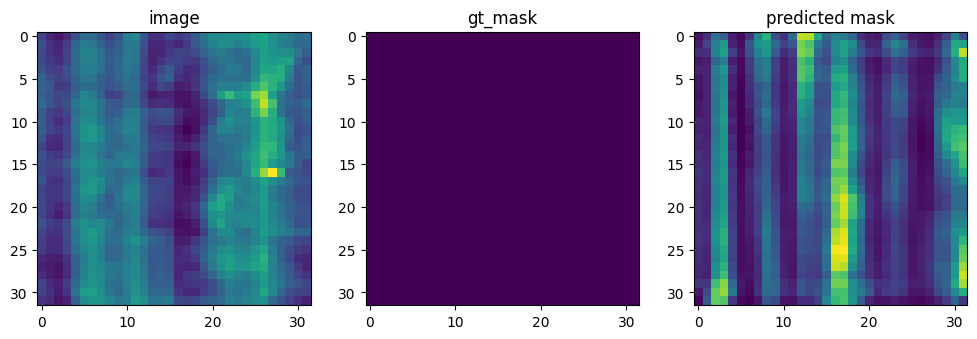

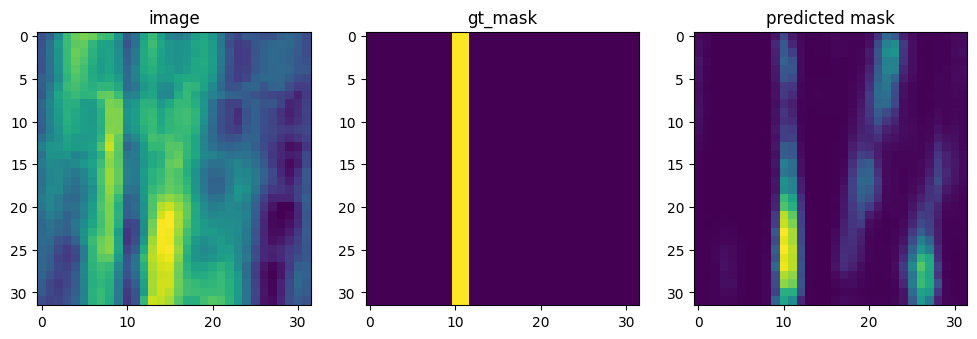

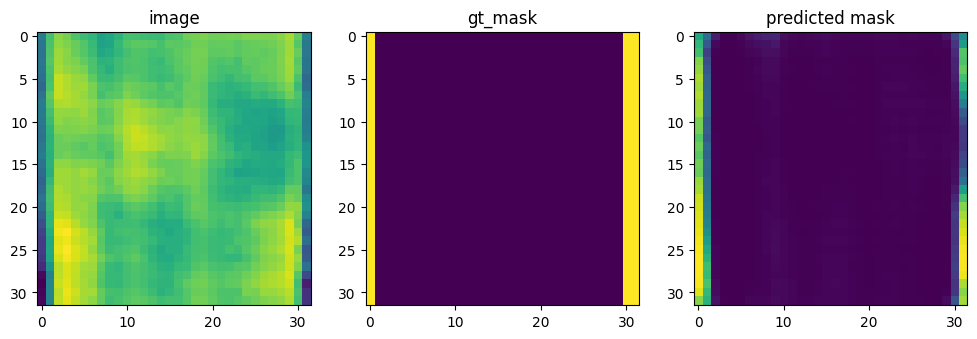

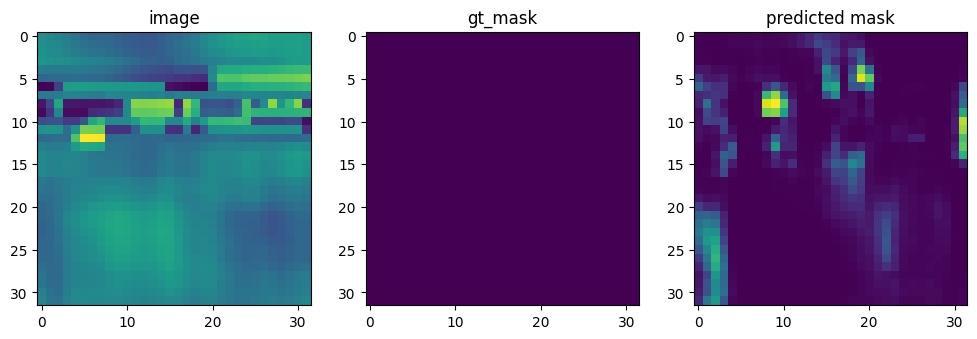

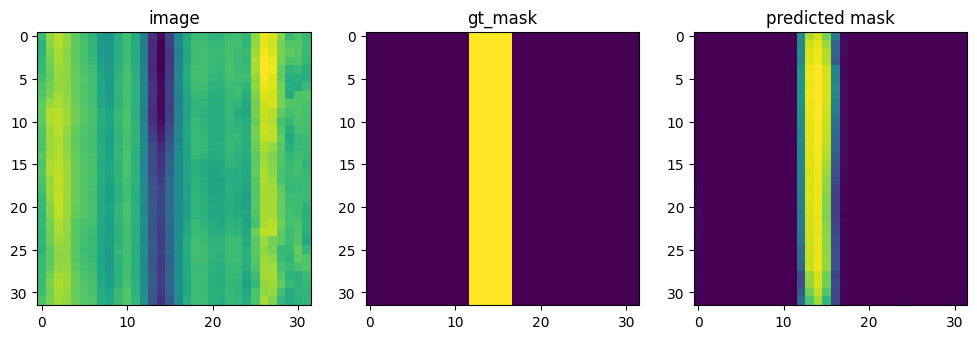

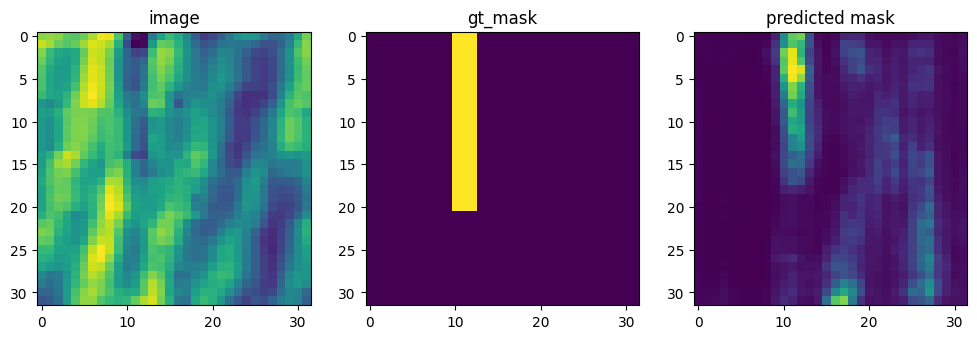

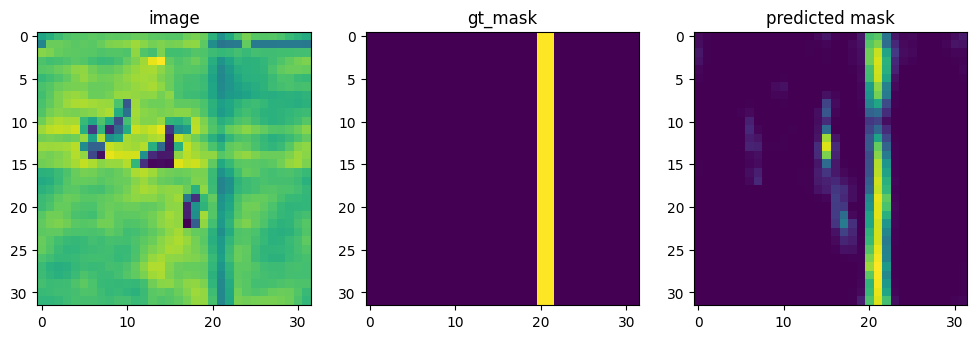

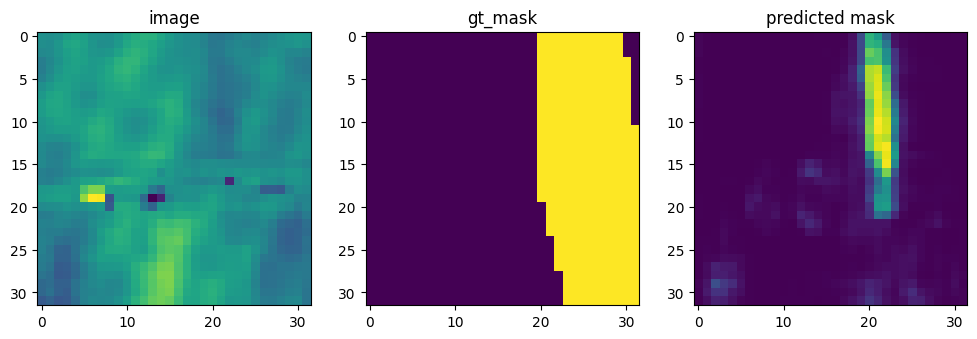

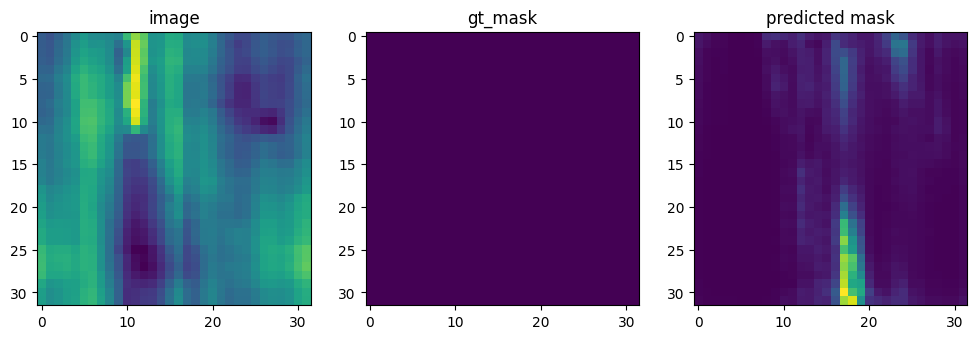

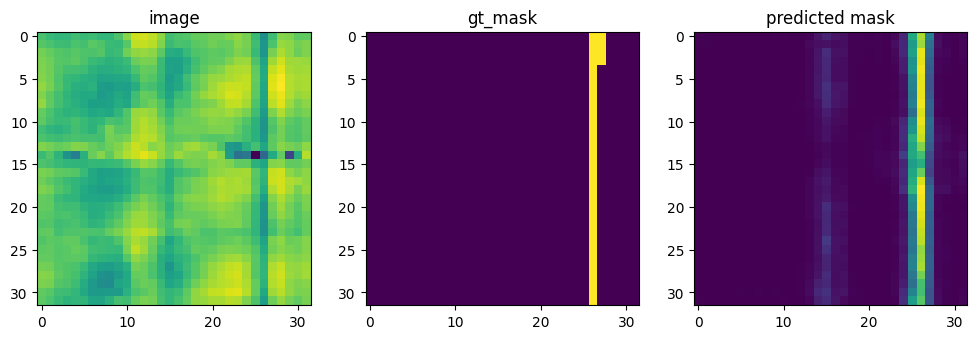

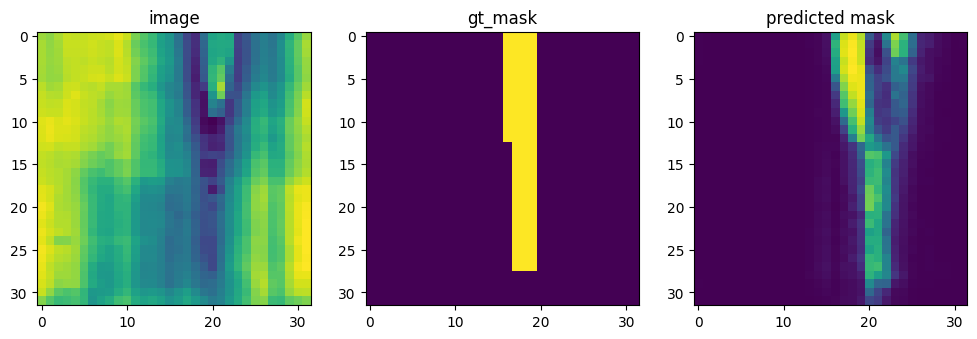

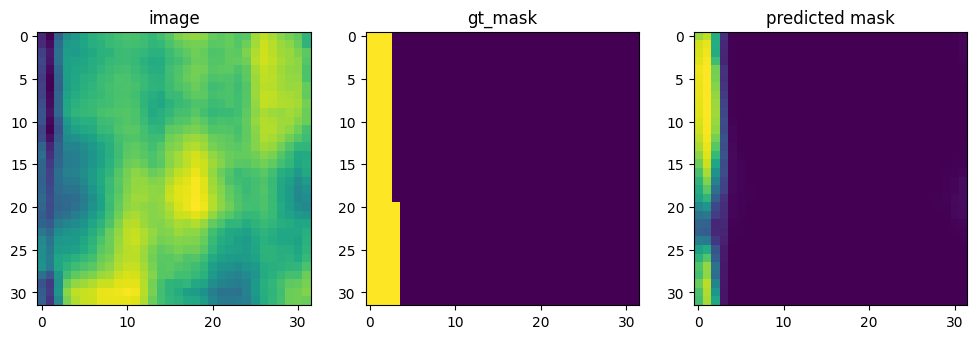

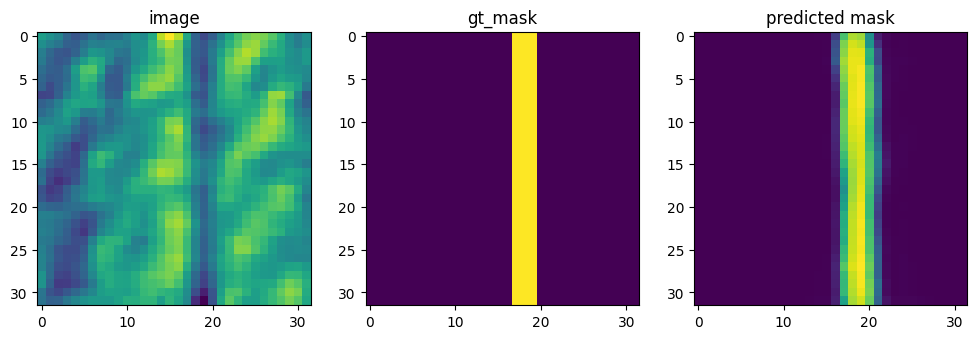

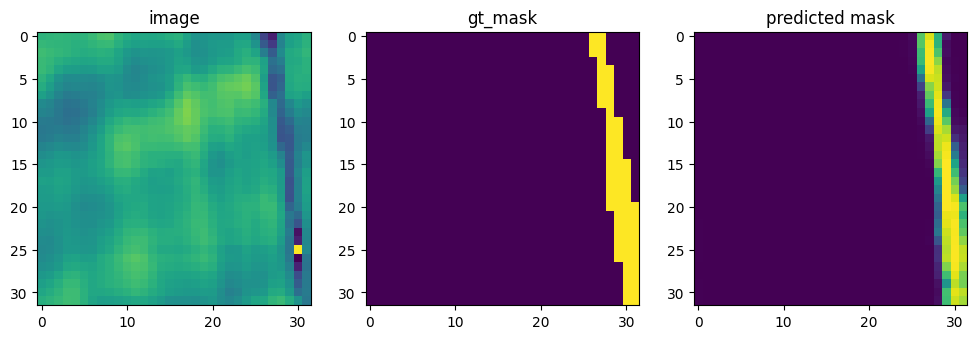

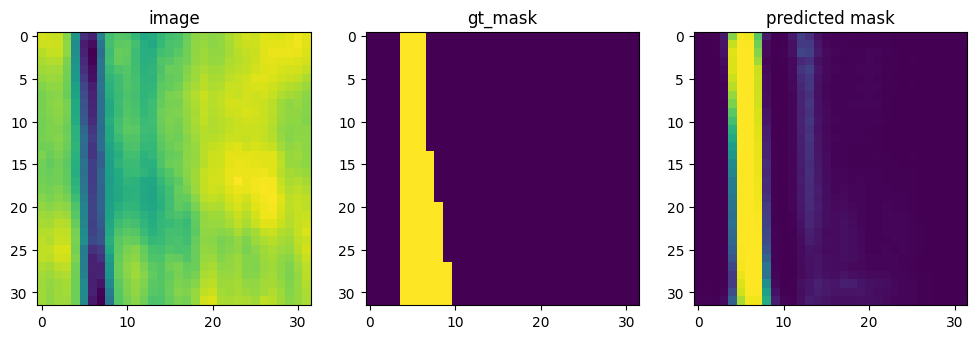

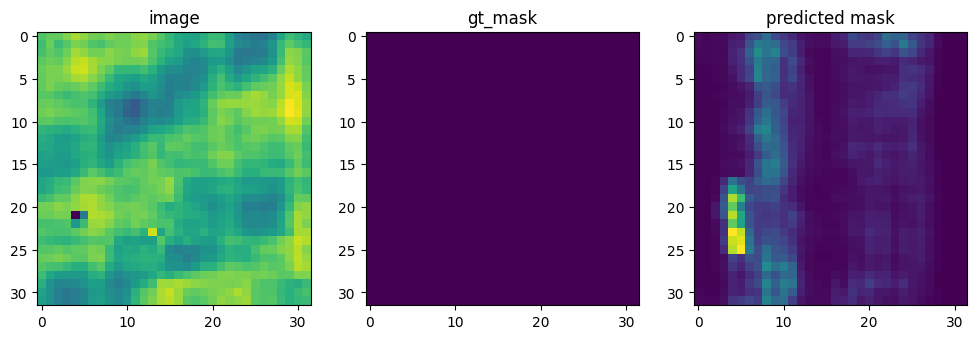

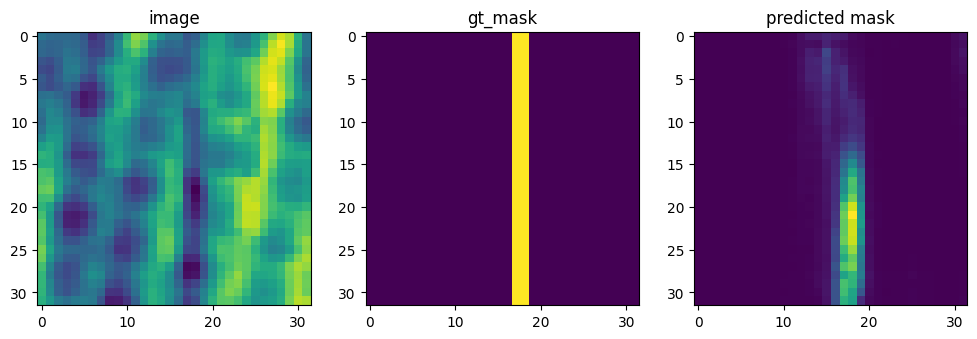

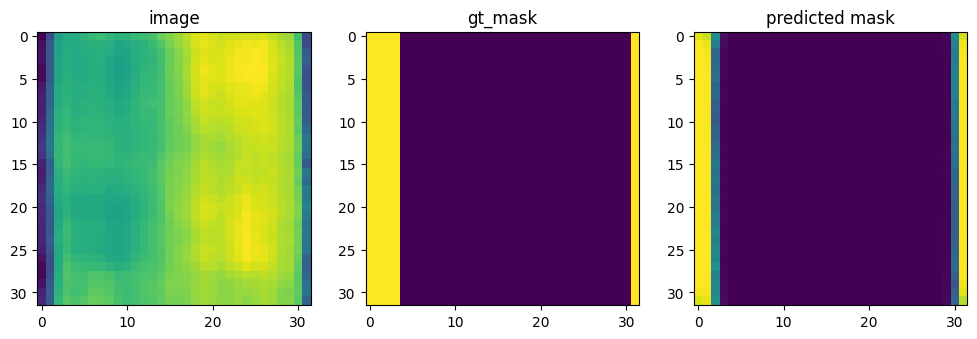

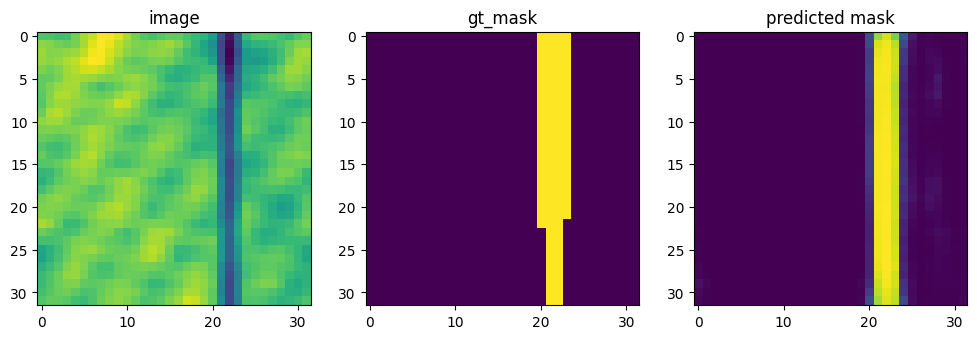

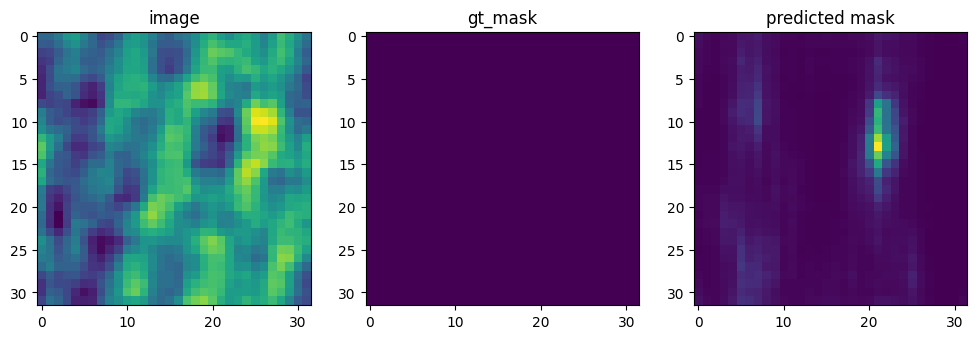

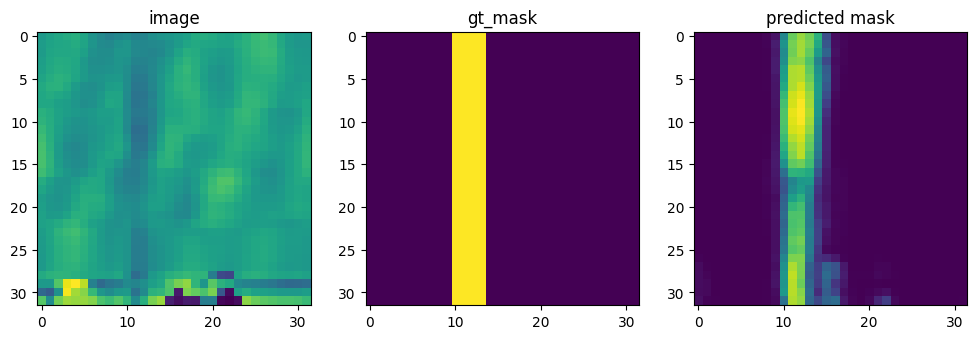

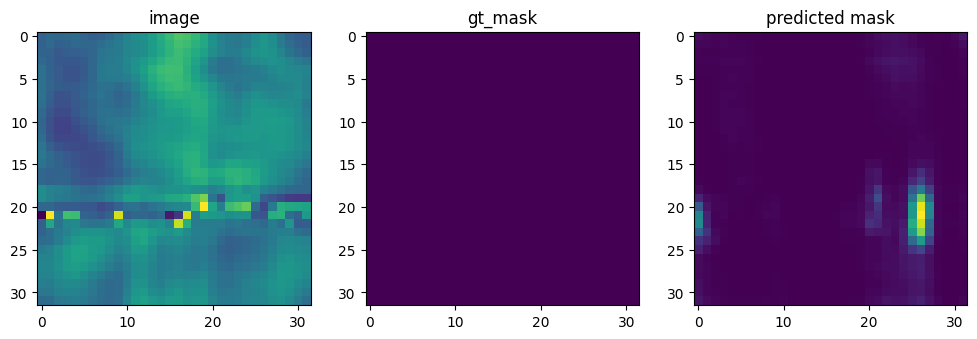

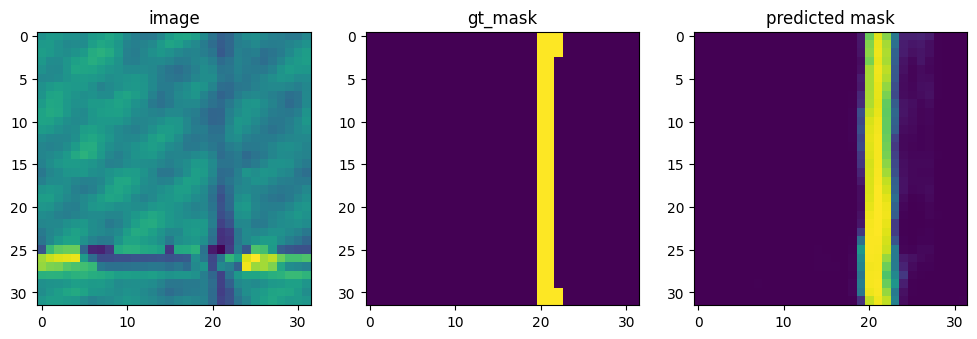

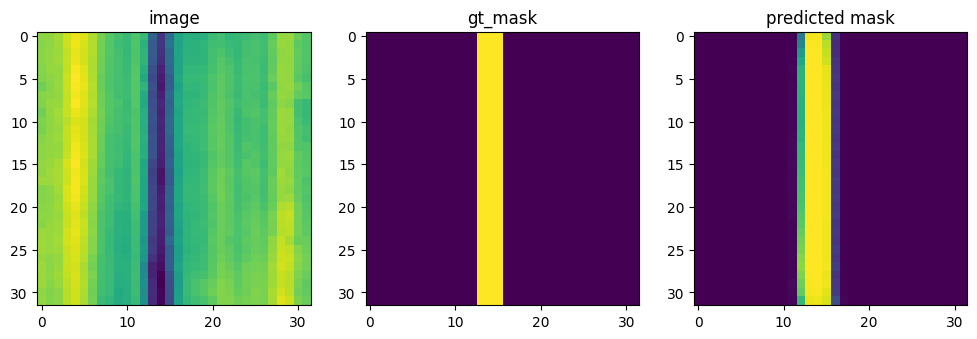

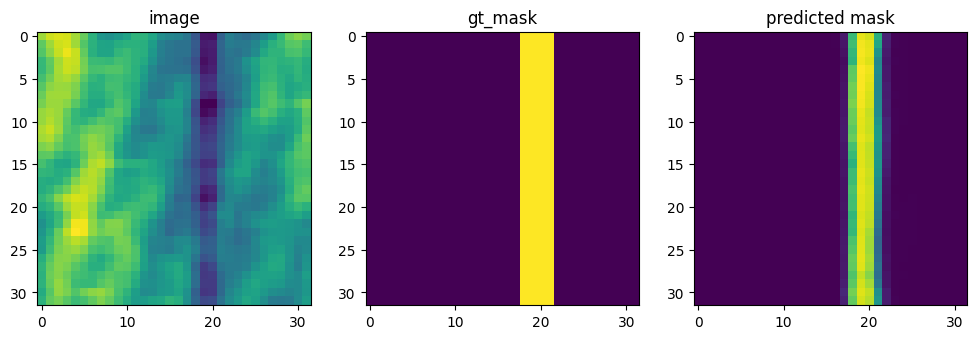

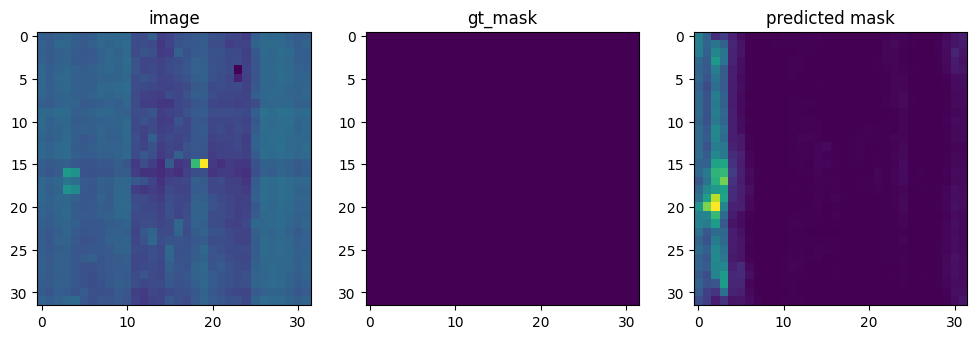

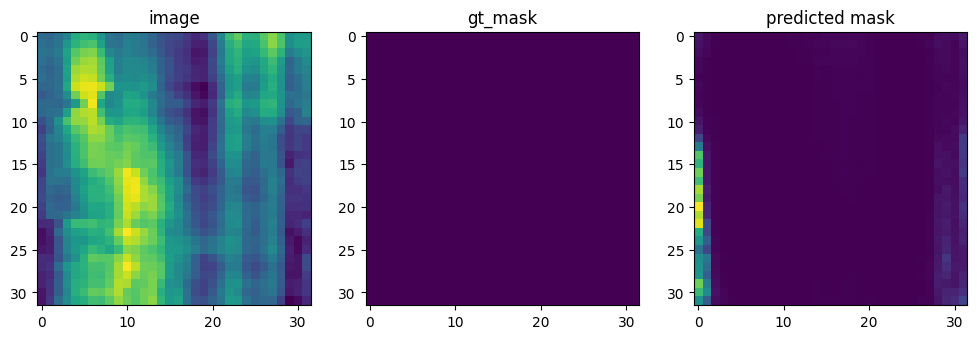

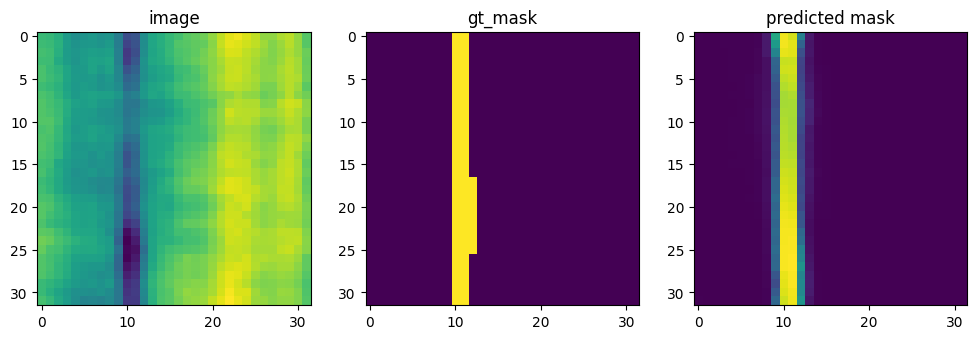

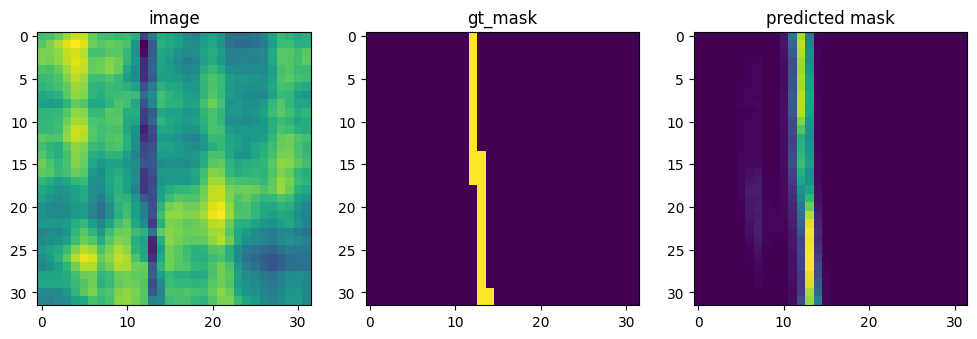

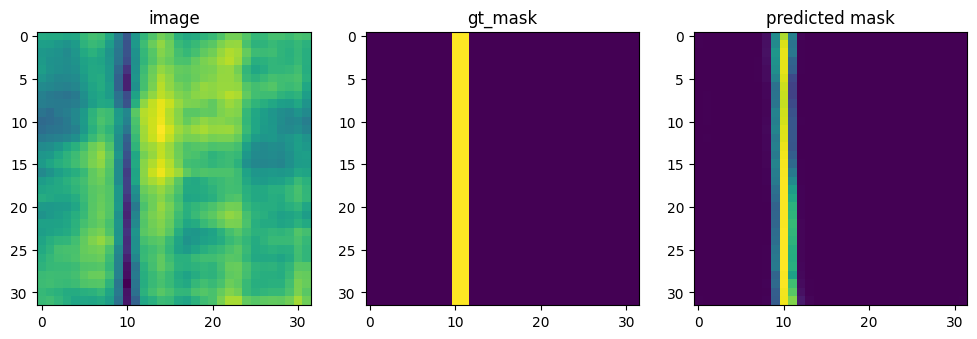

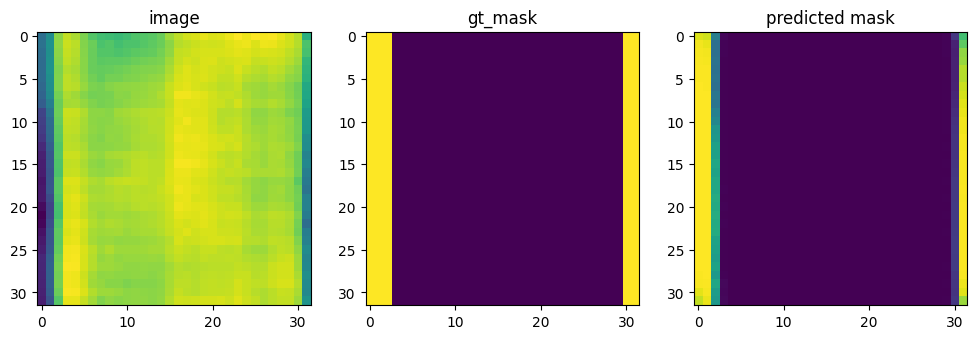

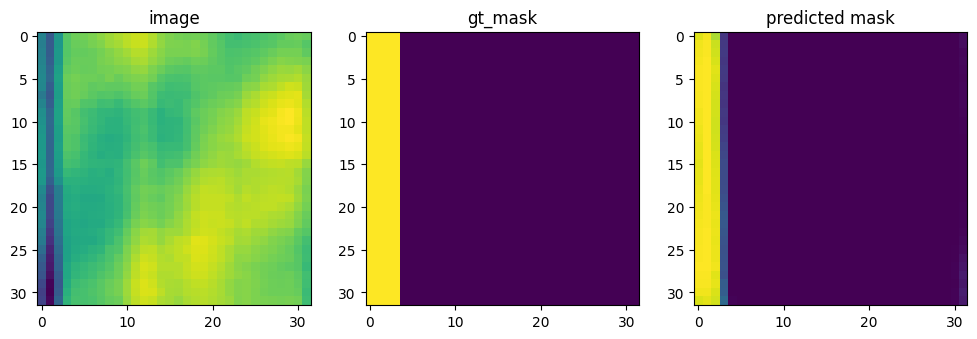

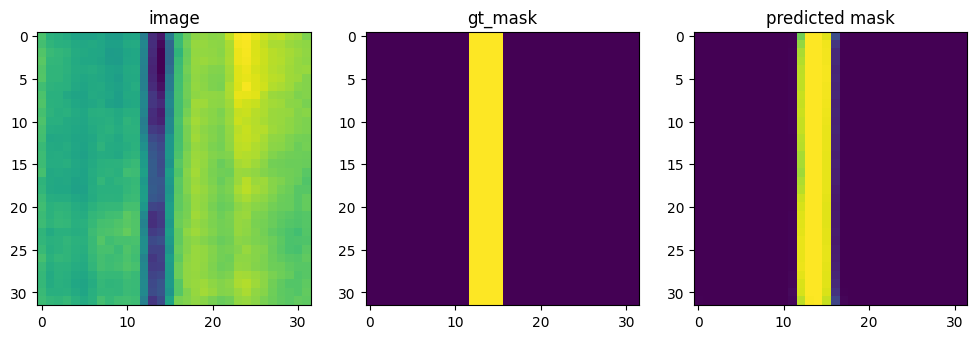

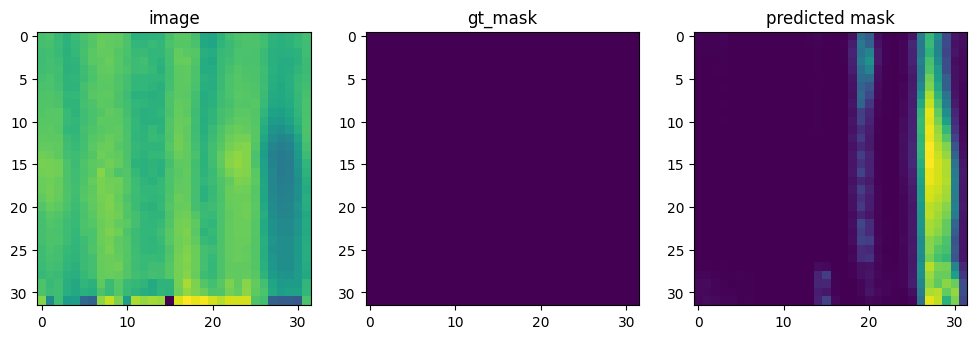

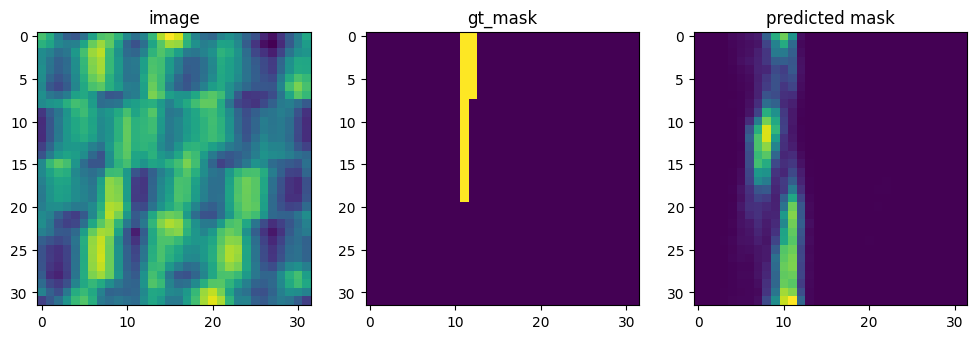

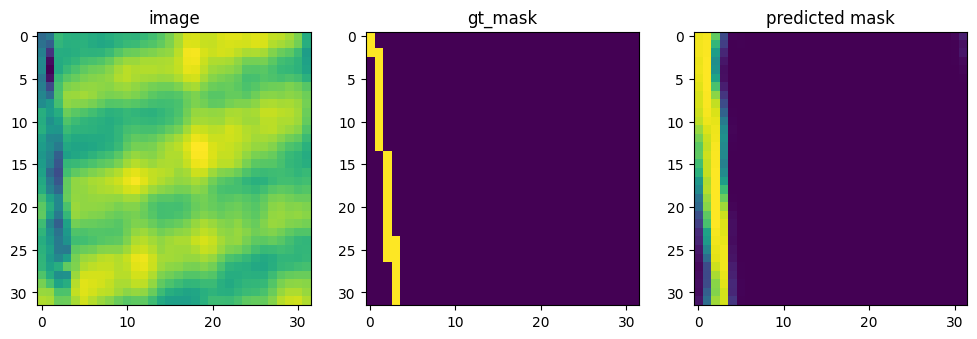

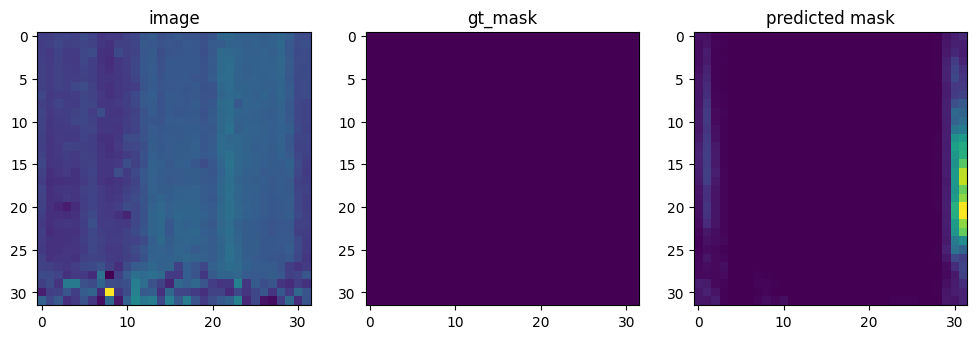

In [15]:
train_losses = []
val_losses = []
train_scores = []
val_scores = []

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    train_score = 0.0

    for i, (images, masks) in enumerate(train_loader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        pred_masks = model(images)
        loss = criterion(pred_masks, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        # Assume dice_score is a function that calculates the score for the batch
        score = dice_score(pred_masks, masks)
        train_score += score.item()

    # Calculate average loss and score for the epoch
    avg_train_loss = train_loss / len(train_loader)
    avg_train_score = train_score / len(train_loader)
    train_losses.append(avg_train_loss)
    train_scores.append(avg_train_score)

    # Print training loss and score
    # print(f'Epoch {epoch}/{epochs - 1}, Train Loss: {avg_train_loss}, Train Score: {avg_train_score}')

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_score = 0.0
    with torch.no_grad():
        for i, (images, masks) in enumerate(val_loader):
            images = images.float().to(device)
            masks = masks.float().to(device)

            pred_masks = model(images)
            loss = criterion(pred_masks, masks)

            val_loss += loss.item()
            # Assume dice_score is a function that calculates the score for the batch
            score = dice_score(pred_masks, masks)
            val_score += score.item()

            # Plot at given intervals
            if i % 20 == 0:
                plot(images.cpu(), masks.cpu(), pred_masks.cpu())

    # Calculate average loss and score for the epoch
    avg_val_loss = val_loss / len(val_loader)
    avg_val_score = val_score / len(val_loader)
    val_losses.append(avg_val_loss)
    val_scores.append(avg_val_score)

    # Print validation loss and score
    print(f'Epoch {epoch}/{epochs - 1}, Train Loss: {avg_train_loss}, Train Score: {avg_train_score}, Val Loss: {avg_val_loss}, Val Score: {avg_val_score}')


we see the results of segmentation are pretty good and the validation score incresed to 0.78

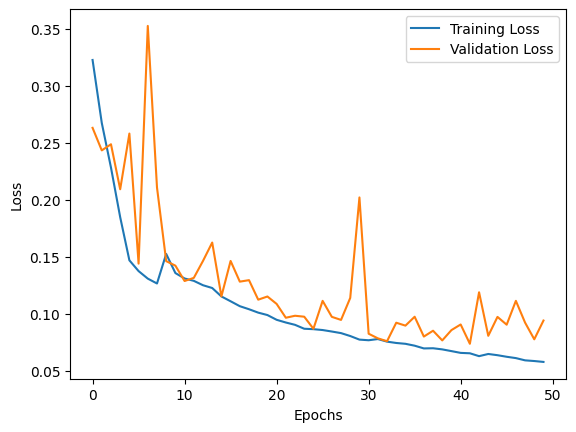

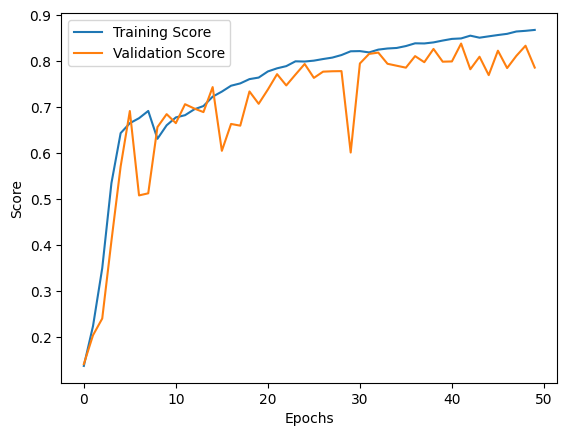

In [16]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Similarly for the scores:
plt.plot(train_scores, label='Training Score')
plt.plot(val_scores, label='Validation Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.show()

we see the validation results are not very smooth.

In [28]:
#save model
save_path= '/content/drive/MyDrive/Geosciences/save/models/trained_unet.pth'
torch.save(model.state_dict(), save_path)


Predictions saved to /content/drive/MyDrive/Geosciences/save/predictions.csv


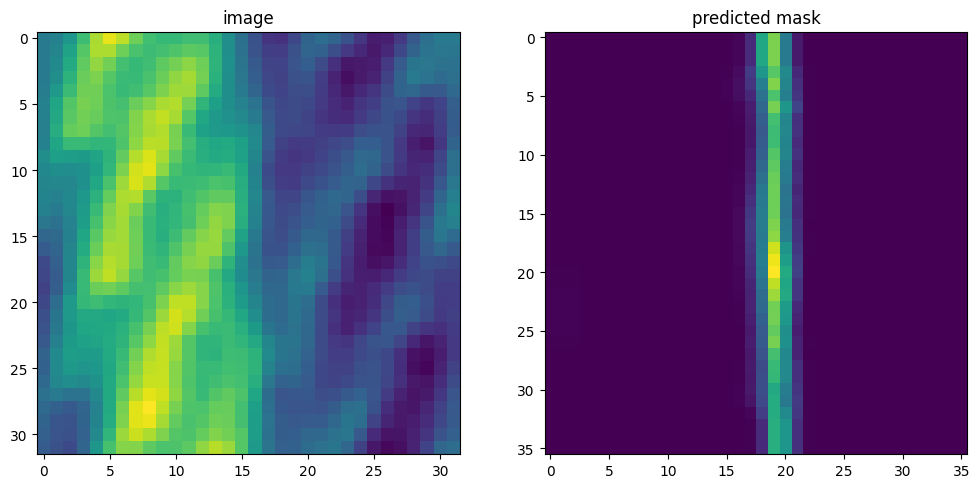

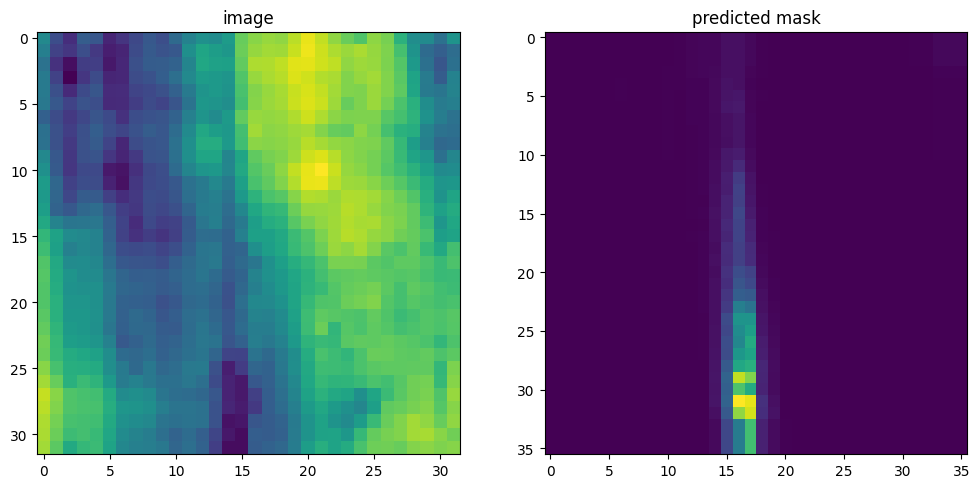

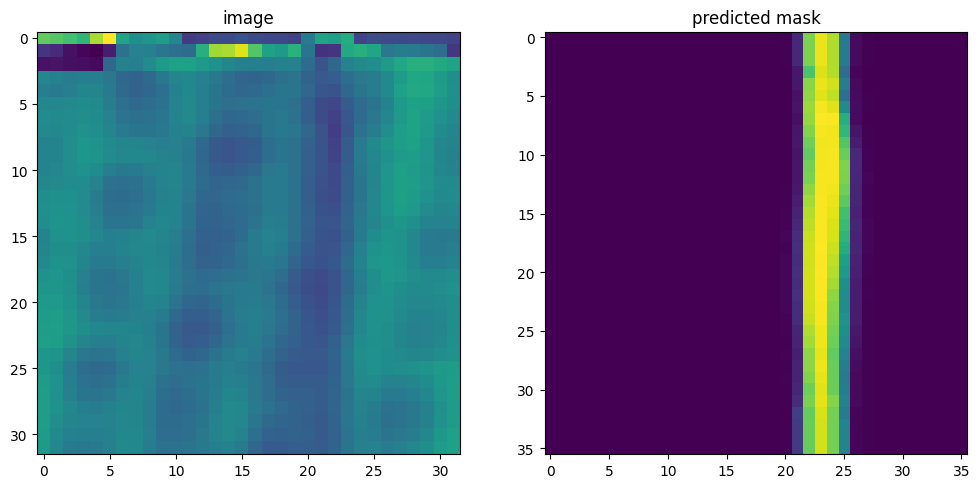

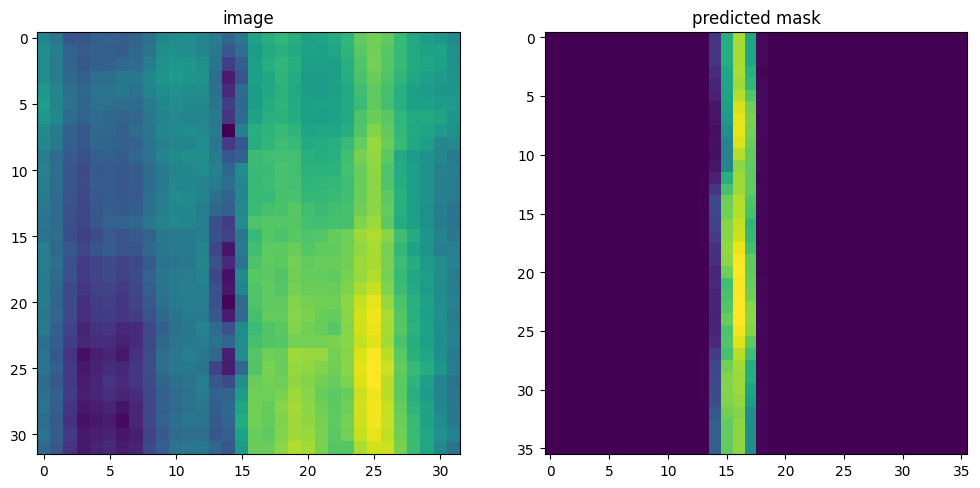

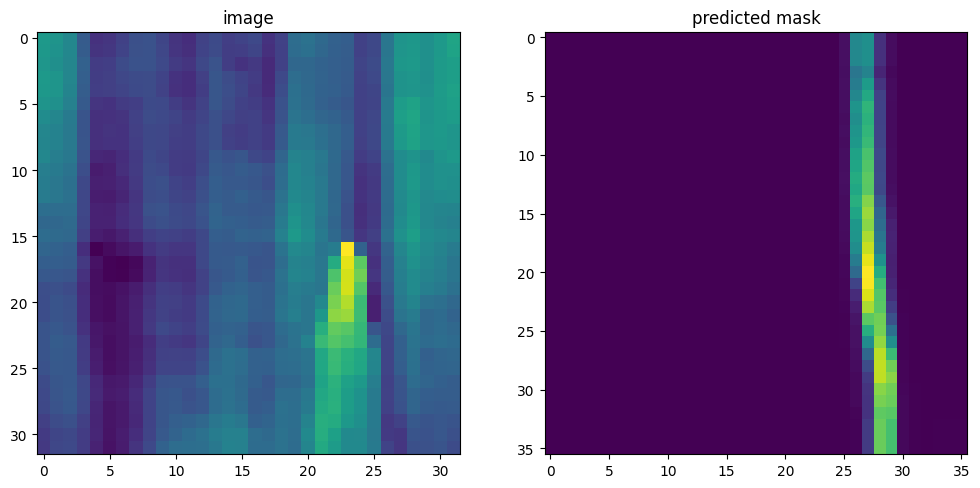

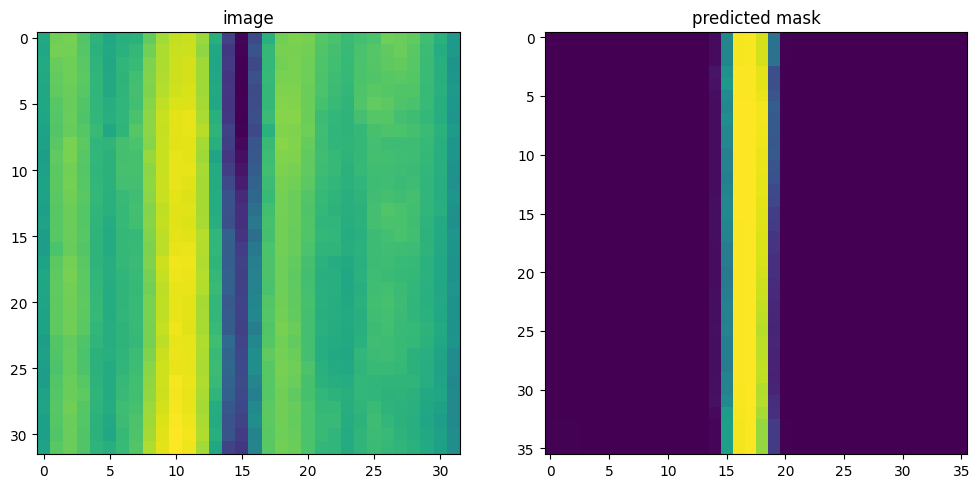

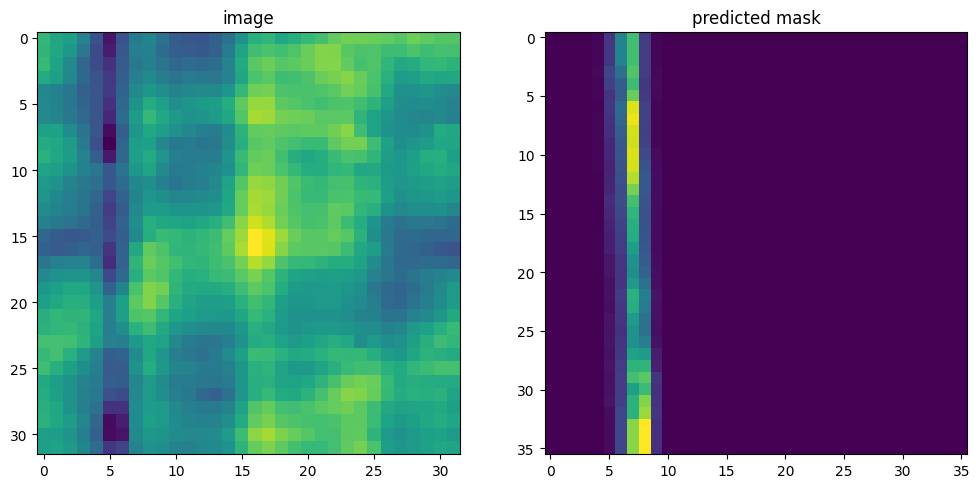

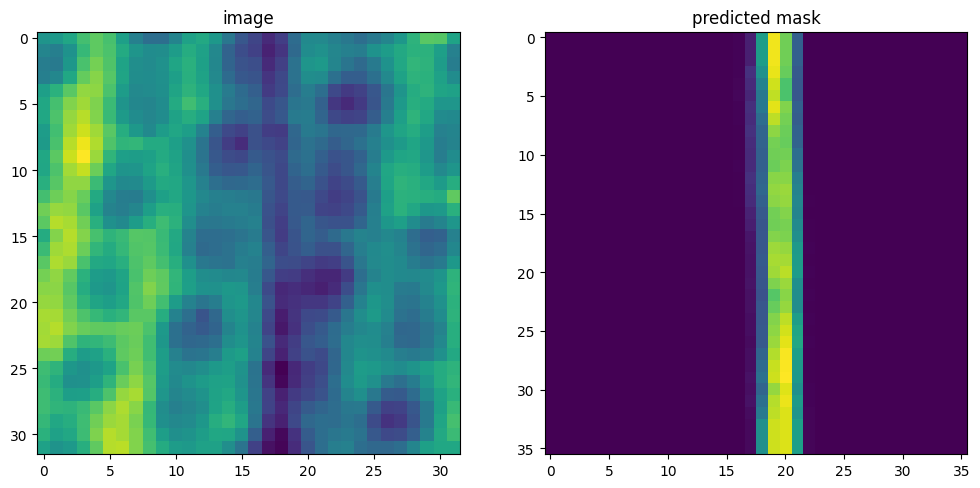

In [23]:
#save predictions
state= torch.load('/content/drive/MyDrive/Geosciences/save/models/trained_unet_2.pth')
model.load_state_dict(state)

model.eval()

predictions = []

with torch.no_grad():
    for i, (images, names) in enumerate(test_loader):
        images = images.to(device).float()

        pred_masks = model(images)
        #restore the original size 36x36 by padding
        pad_size = 2
        pred_masks = F.pad(pred_masks, (pad_size, pad_size, pad_size, pad_size), mode='replicate')

        pred_masks_flat = pred_masks.view(pred_masks.size(0), -1).cpu().numpy()

        for name, pred in zip(names, pred_masks_flat):
            predictions.append([name] + pred.tolist())


        if i % 10 == 0:
            images = images.data.cpu().numpy()
            pred_masks = pred_masks.data.cpu().numpy()
            fig, axs= plt.subplots(1,2,figsize=(12, 7))
            axs[0].imshow(images[0].reshape(32,32,1))
            axs[0].set_title('image')
            axs[1].imshow(pred_masks[0].reshape(36,36,1))
            axs[1].set_title('predicted mask')

#add the two nan pictures that we removed for index consistency
predictions.append(['well_15_patch_201'] + np.zeros_like(pred).tolist())
predictions.append(['well_15_patch_202'] + np.zeros_like(pred).tolist())


predictions.sort(key=lambda x: x[0])

csv_file_path = '/content/drive/MyDrive/Geosciences/save/predictions.csv'


with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Name'] + [f'{i}' for i in range(pred_masks_flat.shape[1])])
    writer.writerows(predictions)

print(f'Predictions saved to {csv_file_path}')



In [24]:
print(len(predictions))

9670


In [25]:
# Read the file
y_train=pd.read_csv('/content/drive/MyDrive/Geosciences/save/predictions.csv', index_col=0)
y_train.head()


,0,1,2,3,4,5,6,7,8,9,...,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295
Image Name,,,,,,,,,,,,,,,,,,,,,
well_10_patch_0,0.003379,0.003379,0.003379,0.005959,0.003297,0.001402,0.000586,0.000306,0.000268,0.000186,...,0.000028,0.000021,0.000261,0.001037,0.047061,0.480965,0.547476,0.280392,0.280392,0.280392
well_10_patch_1,0.000922,0.000922,0.000922,0.002447,0.001599,0.000826,0.000858,0.000685,0.001073,0.000913,...,0.000049,0.000087,0.000317,0.000312,0.000753,0.002474,0.001205,0.002616,0.002616,0.002616
well_10_patch_10,0.003175,0.003175,0.003175,0.003044,0.001115,0.001637,0.000165,0.000095,0.000094,0.000127,...,0.000112,0.000103,0.000852,0.001930,0.007976,0.006337,0.007249,0.008235,0.008235,0.008235
well_10_patch_11,0.004187,0.004187,0.004187,0.006756,0.004358,0.004674,0.000487,0.000333,0.000262,0.000247,...,0.000142,0.000168,0.001892,0.001738,0.003509,0.001825,0.002155,0.004679,0.004679,0.004679
well_10_patch_12,0.002194,0.002194,0.002194,0.001657,0.000609,0.000724,0.000174,0.000299,0.000284,0.000415,...,0.000160,0.000638,0.002090,0.003573,0.003075,0.001036,0.001188,0.003194,0.003194,0.003194
